# Setting Up

I've saved the final model from my training as a .pkl file here on my NUS OneDrive as the file size was too large to upload onto GitHub: 
https://nusu-my.sharepoint.com/:u:/g/personal/e0970506_u_nus_edu/IQB8o5vpF0lOT7wsWtDwRNylAfdRbrpPKSSvfhZb6nLYHT8?e=y00mjI   

Please download the model after logging in with your NUS credentials, and save it within the same folder as this notebook as `model.pkl`.

Please install the necessary packages below if you don't already have them yet. 

In [ ]:
!pip install torch --index-url https://download.pytorch.org/whl/cu121  # Please check the CUDA version supported by your NVIDIA driver to install the right version 
!pip install pandas numpy
!pip install matplotlib
!pip install transformers

In [1]:
import torch
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import pickle
import os
from wordcloud import WordCloud
import seaborn as sns

from transformers import BertTokenizer
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification
from transformers import get_linear_schedule_with_warmup
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from captum.attr import IntegratedGradients
from collections import defaultdict

from collections import Counter
from collections import defaultdict

from scipy.stats import ttest_ind
from scipy.stats import kruskal

Check that there is a GPU available so that PyTorch can leverage CUDA to speed up testing.

In [2]:
print("CUDA available:", torch.cuda.is_available())
print("GPU name:", torch.cuda.get_device_name(0))
print("CUDA version:", torch.version.cuda)

CUDA available: True
GPU name: NVIDIA GeForce GTX 1070
CUDA version: 11.8


In [3]:
print("Total GPU memory (GB):", torch.cuda.get_device_properties(0).total_memory / 1e9)
print("Allocated (GB):", torch.cuda.memory_allocated(0) / 1e9)
print("Reserved (GB):", torch.cuda.memory_reserved(0) / 1e9)


Total GPU memory (GB): 8.58980352
Allocated (GB): 0.0
Reserved (GB): 0.0


In [4]:
# Assign PyTorch to run off GPU
gpu = torch.device("cuda")
torch.cuda.empty_cache()

In [5]:
SEED = 127

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Testing

Load in the model saved previously from training and use it to evaluate the test dataset.

In [6]:
with open('model.pkl', 'rb') as f:
    model = pickle.load(f)

print('Model loaded: ' + os.getcwd() + '\\model.pkl')

Model loaded: c:\Users\yuant\OneDrive\Documents\DSA4262\Assignment 2\model.pkl


In [7]:
df_test = pd.read_csv("dreaddit-test.csv")
df_test.head(3)

id      subreddit post_id sentence_range  \
0    896  relationships  7nu7as       [50, 55]   
1  19059        anxiety  680i6d        (5, 10)   
2   7977           ptsd  8eeu1t        (5, 10)   

                                                text  label  confidence  \
0  Its like that, if you want or not.“ ME: I have...      0         0.8   
1  I man the front desk and my title is HR Custom...      0         1.0   
2  We'd be saving so much money with this new hou...      1         1.0   

   social_timestamp  social_karma  syntax_ari  ...  lex_dal_min_pleasantness  \
0      1.514981e+09            22   -1.238793  ...                    1.0000   
1      1.493348e+09             5    7.684583  ...                    1.4000   
2      1.524517e+09            10    2.360408  ...                    1.1429   

   lex_dal_min_activation  lex_dal_min_imagery  lex_dal_avg_activation  \
0                   1.200                  1.0                 1.65864   
1                   1.125                  1.0                 1.69133   
2                   1.000                  1.0                 1.70974   

   lex_dal_avg_imagery  lex_dal_avg_pleasantness  social_upvote_ratio  \
0              1.32245                   1.80264                 0.63   
1              1.69180                   1.97249                 1.00   
2              1.52985                   1.86108                 1.00   

   social_num_comments  syntax_fk_grade  sentiment  
0                   62        -0.148707   0.000000  
1                    2         7.398222  -0.065909  
2                    8         3.149288  -0.036818  

[3 rows x 116 columns]

In [8]:
print('Number of test posts: {:,}\n'.format(df_test.shape[0]))
text = df_test.text.values
labels = df_test.label.values

Number of test posts: 715



In [9]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

input_ids = []
attention_masks = []
max_len = 0

for post in text:
    input_ids = tokenizer.encode(post, add_special_tokens=True)
    max_len = max(max_len, len(input_ids))

print('Max sentence length in subset: ', max_len)

Max sentence length in subset:  308


In [10]:
input_ids = []
attention_masks = []

for post in text:
    encoded_dict = tokenizer(
        post,   
        add_special_tokens=True,    
        padding='max_length',        
        return_attention_mask=True,   
        return_tensors='pt'           
    )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

In [11]:
batch_size = 32 

prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_dataloader = DataLoader(prediction_data, sampler=SequentialSampler(prediction_data), batch_size=batch_size)

In [12]:
print('Predicting labels for {:,} test comments'.format(len(input_ids)))

model.eval()

predictions , true_labels = [], []

for batch in prediction_dataloader:
    batch = tuple(t.to(gpu) for t in batch)

    batch_input_ids, batch_input_mask, batch_labels = batch

    # Telling the model not to compute or store gradients
    with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(batch_input_ids, 
                     token_type_ids=None, 
                     attention_mask=batch_input_mask,
                     return_dict=True)

    logits = result.logits

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = batch_labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)
    
print('DONE')   

Predicting labels for 715 test comments
DONE


Below shows what the logit outputs look like.

In [13]:
print('Prediction datatype: ', type(predictions))
print('Prediction sample: ', predictions[:1])

# Each row is 1 result, [logit for class 0, logit for class 1]
# Higher logit = more likely predicted class

Prediction datatype:  <class 'list'>
Prediction sample:  [array([[ 1.6194221 , -1.2698629 ],
       [ 1.1349844 , -1.0426434 ],
       [-1.0297871 ,  1.0208027 ],
       [-1.2096267 ,  1.4038298 ],
       [-0.41559377,  0.76430404],
       [ 1.7005568 , -1.4361553 ],
       [ 1.4880594 , -1.4647236 ],
       [-1.267314  ,  1.2000624 ],
       [-1.5861441 ,  1.5187833 ],
       [ 1.5498427 , -1.2005451 ],
       [-0.7621633 ,  1.094284  ],
       [-0.6953511 ,  0.53324413],
       [ 0.3740748 , -0.37558186],
       [-1.6521419 ,  1.5540482 ],
       [-0.7197016 ,  1.1729432 ],
       [ 0.8537673 , -0.54852617],
       [-1.5681558 ,  1.6976994 ],
       [-0.8807905 ,  0.9065635 ],
       [-0.87851524,  0.80658835],
       [ 0.63133675, -0.713554  ],
       [ 1.4319359 , -1.2385535 ],
       [ 1.5727582 , -1.4198979 ],
       [ 1.6261258 , -1.3103316 ],
       [-1.540901  ,  1.3997221 ],
       [-0.81435543,  0.86232436],
       [ 0.93602127, -0.8714268 ],
       [ 0.92870855, -0.8395918 

In [14]:
# Concatenate predictions and labels across batches
logits = np.concatenate(predictions, axis=0)  
labels = np.concatenate(true_labels, axis=0)

# Convert logits to torch tensor
logits_tensor = torch.tensor(logits)

# Obtain probabilities using softmax
probs = F.softmax(logits_tensor, dim=1).numpy()  

# Predicted class and confidence
predicted = np.argmax(probs, axis=1)    
confidence = probs[np.arange(len(probs)), predicted] 

accuracy = accuracy_score(labels, predicted)
precision = precision_score(labels, predicted, pos_label=1)
recall = recall_score(labels, predicted, pos_label=1)
f1 = f1_score(labels, predicted, pos_label=1)

print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")

df_test = df_test.copy()
df_test["predicted"] = predicted
df_test["confidence"] = confidence

Accuracy : 0.8084
Precision: 0.7829
Recall   : 0.8699
F1 Score : 0.8241


My final model achieved an `F1 score of 0.8241` on the test dataset. 

# Analysis

Double check that the test dataset has the attached predicted labels from the model.

In [15]:
df_test.head(3)

id      subreddit post_id sentence_range  \
0    896  relationships  7nu7as       [50, 55]   
1  19059        anxiety  680i6d        (5, 10)   
2   7977           ptsd  8eeu1t        (5, 10)   

                                                text  label  confidence  \
0  Its like that, if you want or not.“ ME: I have...      0    0.947314   
1  I man the front desk and my title is HR Custom...      0    0.898222   
2  We'd be saving so much money with this new hou...      1    0.886007   

   social_timestamp  social_karma  syntax_ari  ...  lex_dal_min_activation  \
0      1.514981e+09            22   -1.238793  ...                   1.200   
1      1.493348e+09             5    7.684583  ...                   1.125   
2      1.524517e+09            10    2.360408  ...                   1.000   

   lex_dal_min_imagery  lex_dal_avg_activation  lex_dal_avg_imagery  \
0                  1.0                 1.65864              1.32245   
1                  1.0                 1.69133              1.69180   
2                  1.0                 1.70974              1.52985   

   lex_dal_avg_pleasantness  social_upvote_ratio  social_num_comments  \
0                   1.80264                 0.63                   62   
1                   1.97249                 1.00                    2   
2                   1.86108                 1.00                    8   

   syntax_fk_grade  sentiment  predicted  
0        -0.148707   0.000000          0  
1         7.398222  -0.065909          0  
2         3.149288  -0.036818          1  

[3 rows x 117 columns]

In [16]:
for col in df_test.columns:
    print(col)

id
subreddit
post_id
sentence_range
text
label
confidence
social_timestamp
social_karma
syntax_ari
lex_liwc_WC
lex_liwc_Analytic
lex_liwc_Clout
lex_liwc_Authentic
lex_liwc_Tone
lex_liwc_WPS
lex_liwc_Sixltr
lex_liwc_Dic
lex_liwc_function
lex_liwc_pronoun
lex_liwc_ppron
lex_liwc_i
lex_liwc_we
lex_liwc_you
lex_liwc_shehe
lex_liwc_they
lex_liwc_ipron
lex_liwc_article
lex_liwc_prep
lex_liwc_auxverb
lex_liwc_adverb
lex_liwc_conj
lex_liwc_negate
lex_liwc_verb
lex_liwc_adj
lex_liwc_compare
lex_liwc_interrog
lex_liwc_number
lex_liwc_quant
lex_liwc_affect
lex_liwc_posemo
lex_liwc_negemo
lex_liwc_anx
lex_liwc_anger
lex_liwc_sad
lex_liwc_social
lex_liwc_family
lex_liwc_friend
lex_liwc_female
lex_liwc_male
lex_liwc_cogproc
lex_liwc_insight
lex_liwc_cause
lex_liwc_discrep
lex_liwc_tentat
lex_liwc_certain
lex_liwc_differ
lex_liwc_percept
lex_liwc_see
lex_liwc_hear
lex_liwc_feel
lex_liwc_bio
lex_liwc_body
lex_liwc_health
lex_liwc_sexual
lex_liwc_ingest
lex_liwc_drives
lex_liwc_affiliation
lex_liwc_ach

In [17]:
df_test[["label", "predicted", "confidence"]].head()


label  predicted  confidence
0      0          0    0.947314
1      0          0    0.898222
2      1          1    0.886007
3      1          1    0.931723
4      0          1    0.764929

## 1. Stress Expression: which words contribute most to stress prediction?

To better understand how the model conceptualizes stress, I'll first examine the words that contribute most strongly to stress prediction. I will look at word-level attribution scores and visualize them using word clouds, to get a better overview of the linguistic signals the model relies on. 

A custom stopword list was applied to remove some high-frequency grammatical and function words that do not contribute much meaningful semantic information on their own to stress detection. This preprocessing step will hopefully help enhance interpretability of word-level contributions, particularly in wordcloud visualizations.

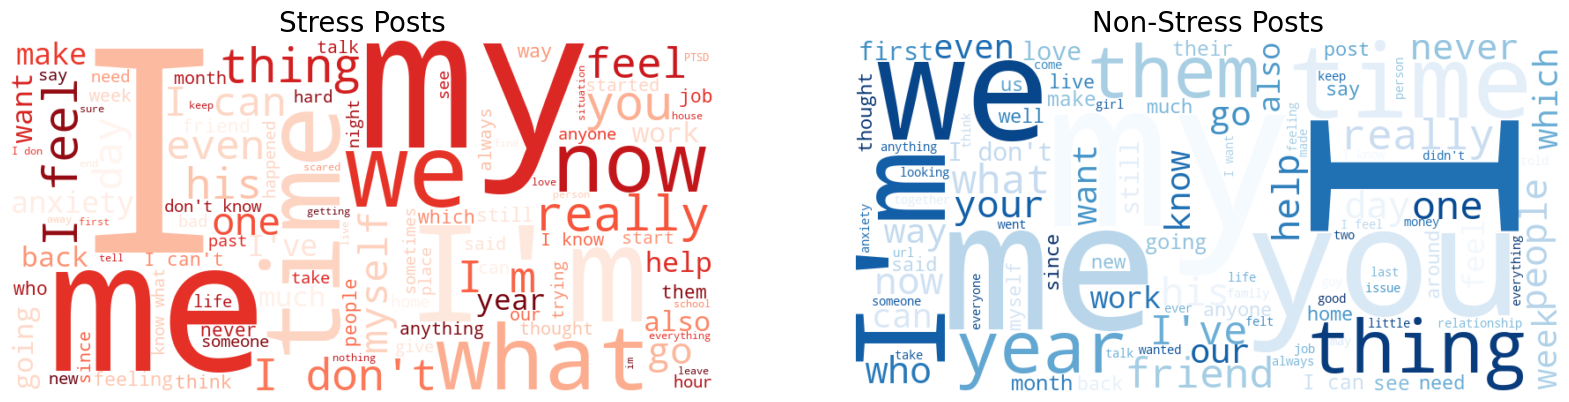

In [19]:
custom_stopwords = [
    "this", "that", "these", "those",
    "am", "is", "are", "was", "were", "be", "been", "being",
    "have", "has", "had", "having",
    "do", "does", "did", "doing",
    "a", "an", "the",
    "and", "but", "if", "or", "because", "as", "until", "while",
    "of", "at", "by", "for", "with", "about", "against", "between",
    "into", "through", "during", "before", "after", "above", "below",
    "to", "from", "up", "down", "in", "out", "on", "off", "over", "under",
    "again", "further", "then", "once",
    "here", "there", "when", "where", "why", "how",
    "all", "any", "both", "each", "few", "more", "most", "other", "some", "such",
    "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very",
    "s", "t", "like", "something", "it", "she", "he", "they", "will", "would", "should", "get", "him", "her", "just",
    "got", "hi"
]

stopwords = set(custom_stopwords)

text_stress = " ".join(df_test[df_test['label']==1]['text'].dropna().tolist())
text_nonstress = " ".join(df_test[df_test['label']==0]['text'].dropna().tolist())

wc_stress = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords, colormap='Reds', max_words=100).generate(text_stress)
wc_nonstress = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords, colormap='Blues', max_words=100).generate(text_nonstress)

plt.figure(figsize=(20,8))

plt.subplot(1,2,1)
plt.imshow(wc_stress, interpolation='bilinear')
plt.axis('off')
plt.title("Stress Posts", fontsize=20)

plt.subplot(1,2,2)
plt.imshow(wc_nonstress, interpolation='bilinear')
plt.axis('off')
plt.title("Non-Stress Posts", fontsize=20)

plt.show()

Here, I plotted out wordclouds of the common words found in 'Stress' vs 'Non-Stressed' posts (i.e. their occurance frequencies). Both types of posts involve heavy use of first-person pronouns (“I”, “me”, “my”), which makes sense as the posts are of users sharing their own experiences and feelings. However, the 'Non-Stressed' posts seem to have more of “you” and “we”, which could be an indication of users of non-stressed posts talking about others or shared experiences rather than just themselves.  

This aligns with [research results](https://www.sciencedirect.com/science/article/abs/pii/S0092656616302884?) where higher first-person singular pronouns usage is often correlated with stress, poor mental state and depression.

### 1.1: Top words that contribute towards predicting stress (across all subreddits)

Captum is an open source, extensible library for model interpretability built on PyTorch. I use [Integrated Gradients](https://captum.ai/api/integrated_gradients.html) (IG), one of the feature attribution algorithms available in Captum, to learn more about the words driving stress prediction. Integrated Gradients assigns an importance score to each input token by approximating the integral of the gradients of the model’s output with respect to the inputs.

I first test out Integrated Gradients by taking a sample stress post and getting the top 10 words driving stress prediction from this one sample post.

In [21]:
# Pick a sample stress post
sample_text = df_test[df_test['label']==1]['text'].iloc[10]
inputs = tokenizer(sample_text, return_tensors='pt')
inputs = {k: v.to(gpu) for k,v in inputs.items()}

# Get embeddings from BERT
input_embeds = model.bert.embeddings.word_embeddings(inputs['input_ids'])
attention_mask = inputs['attention_mask']

In [22]:
def forward_embeds(embeddings, attention_mask):
    outputs = model(inputs_embeds=embeddings, attention_mask=attention_mask)
    probs = torch.softmax(outputs.logits, dim=1)
    return probs[:, 1]

In [23]:
ig = IntegratedGradients(forward_embeds)

attributions, delta = ig.attribute(
    input_embeds,
    additional_forward_args=(attention_mask,),
    target=None,
    return_convergence_delta=True
)

In [23]:
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
token_scores = attributions.sum(dim=-1).squeeze(0).detach().cpu().numpy()
token_importance = list(zip(tokens, token_scores))
token_importance = sorted(token_importance, key=lambda x: abs(x[1]), reverse=True)

token_importance[:10]

[('anxiety', 0.23535639),
 ('[SEP]', -0.17723897),
 ('##thi', 0.09787201),
 ('awkward', 0.097593896),
 ('over', 0.05572588),
 ('get', 0.04782787),
 ('days', 0.040387467),
 ('##nk', 0.039405786),
 ('attractive', -0.033792667),
 ('value', -0.030864555)]

Here we see the token-level attribution scores, where the second value represents the IG attribution score for that token.

- Positive score → the token pushes the model toward predicting stress
- Negative score → the token pushes the model away from predicting stress, i.e., toward non-stress

The magnitude of the score matters: the larger the absolute value, the stronger the influence of that token on the prediction.
e.g. 'anxiety' with 0.235 has the strongest influence on the model towards predicting stress.

IG gives importance per token in context, so the same word can have different effects depending on surrounding words.

Below, I run IG for all the posts in the test dataset to see the top 20 tokens with the largest magnitude of attribution scores.

In [31]:
all_token_scores = defaultdict(list)

for text in df_test[df_test['label']==1]['text'].tolist():
    inputs = tokenizer(text, return_tensors='pt', truncation=True)
    inputs = {k: v.to(gpu) for k,v in inputs.items()}
    input_embeds = model.bert.embeddings.word_embeddings(inputs['input_ids'])
    attention_mask = inputs['attention_mask']
    
    attributions = ig.attribute(
    input_embeds,
    additional_forward_args=(attention_mask,),
    target=None)

    token_scores = attributions.sum(dim=-1).squeeze(0).detach().cpu().numpy()
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
    
    for t,s in zip(tokens, token_scores):
        all_token_scores[t].append(s)

# Compute mean attribution per token
mean_token_scores = {t: np.mean(scores) for t,scores in all_token_scores.items()}
# Sort by absolute value
sorted_tokens = sorted(mean_token_scores.items(), key=lambda x: abs(x[1]), reverse=True)
sorted_tokens[:20]


[('virginity', 0.2645004),
 ('troubled', 0.24551313),
 ('##broken', 0.22129923),
 ('preface', -0.1816256),
 ('pissed', 0.18068683),
 ('difficulty', 0.15304899),
 ('forgive', 0.1458584),
 ('cage', 0.14153561),
 ('[SEP]', -0.14098725),
 ('survivor', -0.13650727),
 ('hurting', 0.12746957),
 ('doping', 0.120019525),
 ('confused', 0.11982088),
 ('hid', 0.119311966),
 ('hated', 0.11199791),
 ('genetically', -0.11148425),
 ('quotes', -0.10590703),
 ('worried', 0.10539095),
 ('flashlight', -0.10482693),
 ('##bid', 0.10373759)]

BERT sometimes gives high attribution to special tokens like [SEP] because they act as aggregation points for contextual information. However, these attributions do not directly correspond to semantically meaningful words in the input text. Since the goal of this section is word-level interpretability, I will exclude these special tokens from my analysis.   

BERT also splits rare or long words into subwords. Subwords that continue a word are prefixed with ##. Here, I'll preserve the subword tokens to reflect the model’s actual tokenization granularity.

In [32]:
def clean_tokens(mean_token_scores):
    cleaned_scores = {}
    for token, score in mean_token_scores.items():
        if token in ["[CLS]", "[SEP]", "[PAD]"]:
            continue  
        cleaned_scores[token] = score
    return cleaned_scores

In [33]:
cleaned_scores = clean_tokens(mean_token_scores)

positive_scores = {token: score for token, score in cleaned_scores.items() if score > 0}
positive_scores = dict(sorted(positive_scores.items(), key=lambda x: x[1], reverse=True))

list(positive_scores.items())[:20]

[('virginity', 0.2645004),
 ('troubled', 0.24551313),
 ('##broken', 0.22129923),
 ('pissed', 0.18068683),
 ('difficulty', 0.15304899),
 ('forgive', 0.1458584),
 ('cage', 0.14153561),
 ('hurting', 0.12746957),
 ('doping', 0.120019525),
 ('confused', 0.11982088),
 ('hid', 0.119311966),
 ('hated', 0.11199791),
 ('worried', 0.10539095),
 ('##bid', 0.10373759),
 ('refuse', 0.10285269),
 ('pointless', 0.10138635),
 ('usual', 0.10117869),
 ('regret', 0.1004184),
 ('jumps', 0.09588146),
 ('abuses', 0.09463582)]

Above shows the list of the top 20 tokens with positive attributions (i.e. drives model towards predicting stress), which reveals that the model assigns the high positive attributions to words associated with emotional distress, negative experiences, and psychological conflict.   

Words such as "troubled", "pissed", "worried", "hated", and "hurting" signal **strong intensity and negative emotions**, which aligns with the model learning to detect stress-related language. As for signals of difficult experiences, words like "difficulty", "regret", "pointless", "confused", "abuses" and "cage" suggest **personal struggles, constraints, or feelings of entrapment**. The model also picks up on **mentions of sensitive topics** through terms such as "virginity" and "doping", which can be personal and potentially distressing topics. 

The model effectively identifies key lexical markers of stress, focusing on emotional intensity, personal struggle, and sensitive topics.

In [34]:
negative_scores = {token: score for token, score in cleaned_scores.items() if score < 0}
negative_scores = dict(sorted(negative_scores.items(), key=lambda x: x[1]))

list(negative_scores.items())[:20]

[('preface', -0.1816256),
 ('survivor', -0.13650727),
 ('genetically', -0.11148425),
 ('quotes', -0.10590703),
 ('flashlight', -0.10482693),
 ('format', -0.102250494),
 ('enjoy', -0.092871614),
 ('title', -0.08563417),
 ('##hetic', -0.085097),
 ('alleviate', -0.08442385),
 ('yep', -0.08419398),
 ('theme', -0.08131197),
 ('humans', -0.08033182),
 ('template', -0.08018285),
 ('alright', -0.07845411),
 ('upgraded', -0.07148886),
 ('core', -0.06666304),
 ('device', -0.06606893),
 ('kentucky', -0.06557516),
 ('encouraged', -0.06475795)]

These are the top 20 tokens with negative attributions, meaning they play a huge part in decreasing the model’s predicted probability of stress i.e. they are associated with non-stressed posts. 

This includes **positive coping words** such as "enjoy", "alleviate" and "encouraged" which could indicate self-care or positive habits. It is interesting that **structural words** like "preface", "quotes", "format", "title", "template", "theme" have relatively strong negative attributions. Structured language tends to be less emotionally charged, which may be why the model associates them with non-stressed content. There are also quite a few **topic-specific nouns** (such as "kentucky", "flashlight") that are content-oriented rather than emotionally expressive.

Comparing the top 20 tokens of both positive and negative attributions, we can see that the positive attributions are overall stronger in magnitude than the negative ones. This suggests that stress-indicative words exert stronger directional influence on predictions than non-stress words. 

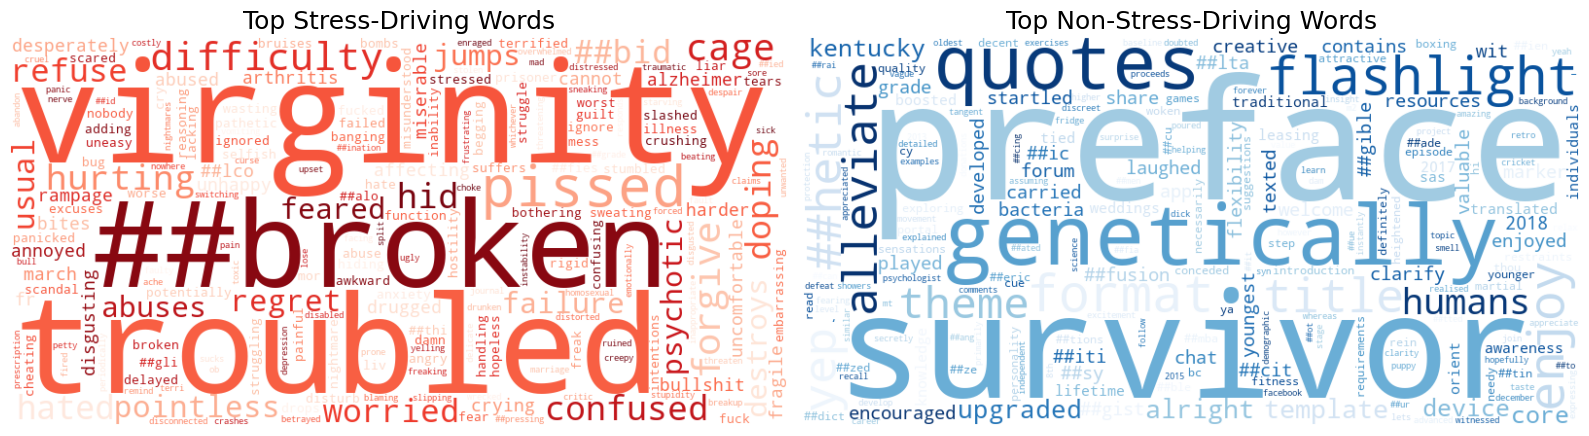

In [40]:
positive_scores = {t: s for t, s in cleaned_scores.items() if s > 0}
negative_scores = {t: -s for t, s in cleaned_scores.items() if s < 0}  # make positive for WordCloud

def plot_wordcloud(scores_dict, ax, title="Word Cloud", colormap='Reds'):
    wc = WordCloud(width=800, height=400, background_color='white', colormap=colormap)
    wc = wc.generate_from_frequencies(scores_dict)
    
    ax.imshow(wc, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(title, fontsize=18)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

plot_wordcloud(positive_scores, axes[0], title="Top Stress-Driving Words", colormap='Reds_r')
plot_wordcloud(negative_scores, axes[1], title="Top Non-Stress-Driving Words", colormap='Blues_r')

plt.tight_layout()
plt.show()


Above shows the wordcloud summarizing the previous findings, where the word size in the cloud represents contribution strength to the model’s prediction (and not how often the word appears in the dataset).   

It is slightly surprisng that "virginity" has such high attribution for stress prediction, especially when it is a word that is topic-specific and not inherently emotional. It isn't a classic stress lexicon word like anxious, depressed, or overwhelmed. The same can be said for some of the strong non-stress indicators like “preface”. It is not emotionally positive and has no inherent anti-stress meaning either, but it strongly pushes predictions toward non-stress.   

The model may have learned that certain topics are strongly associated with stress expression, and rather than purely detecting emotional tone, the model is also detecting stress-associated themes. However, this could be risky as well if such neutral words were to appear in non-stress contexts but the model treats them as a stress indicator.

### 1.2: Comparing top stress-predictive words within each subreddit

I want to find out what words most strongly drive the model’s stress predictions within each subreddit.  

In the code above, I collect token attributions across all posts in each subreddit, and average each token’s score across posts to capture general stress cues per community. Word size in the clouds reflects the magnitude of average IG attribution for that word, where larger words indicate stronger influence on the model’s stress prediction.

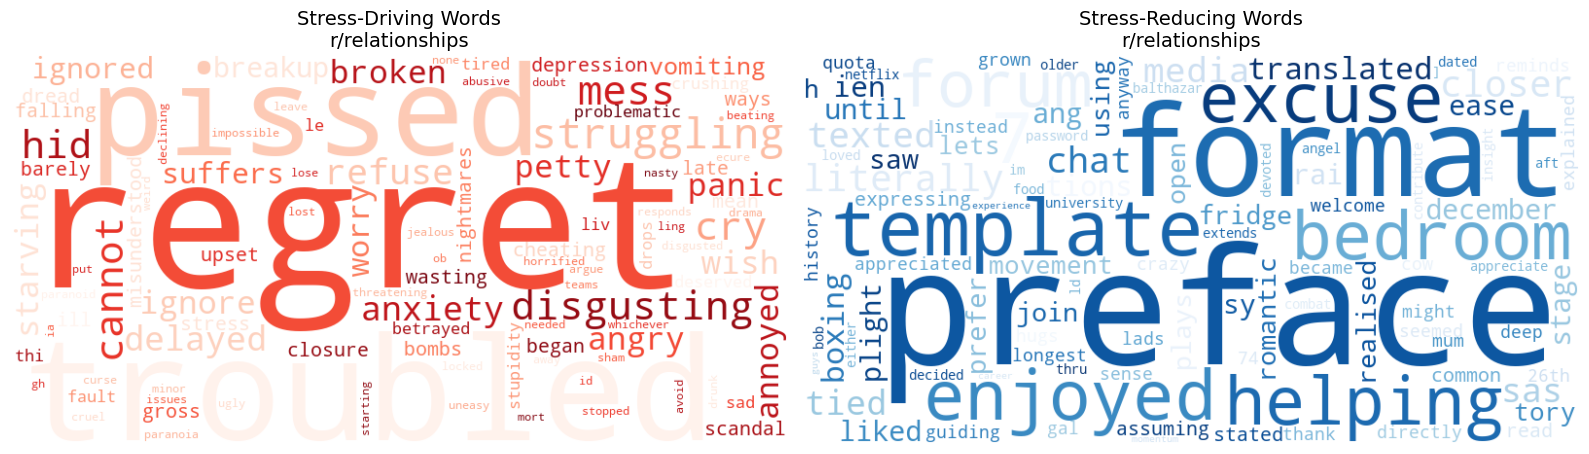

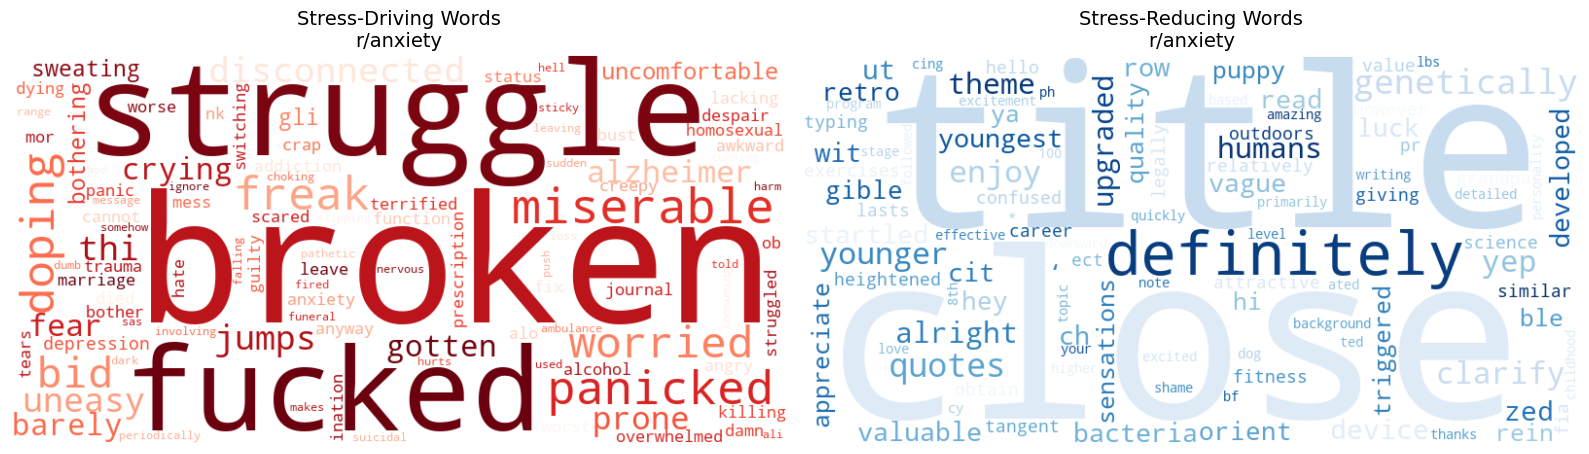

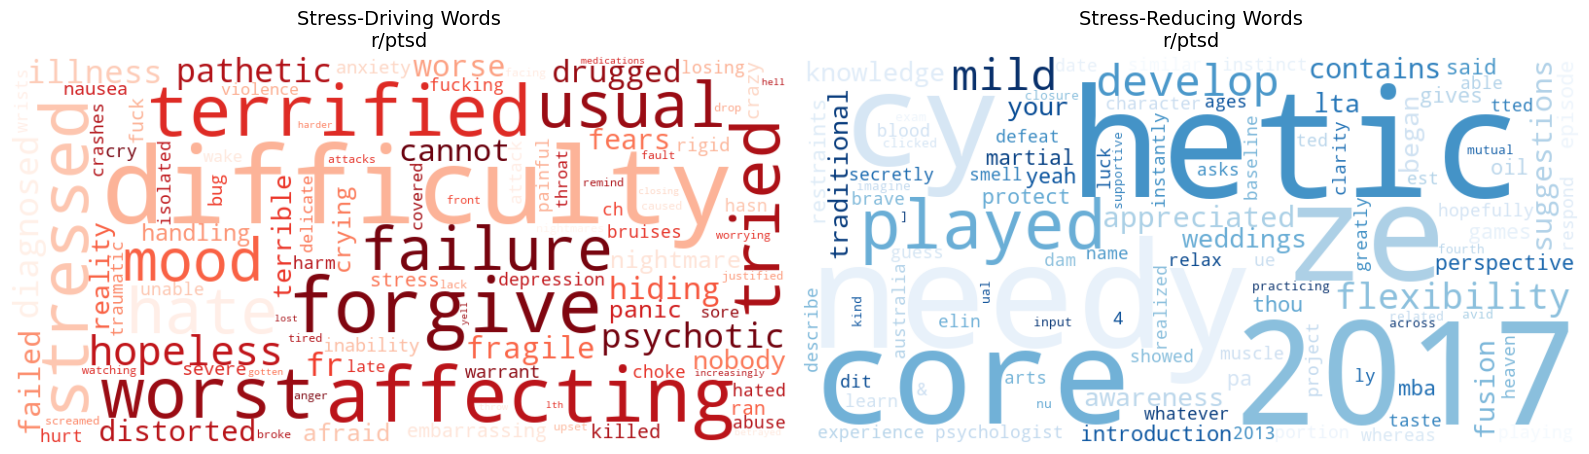

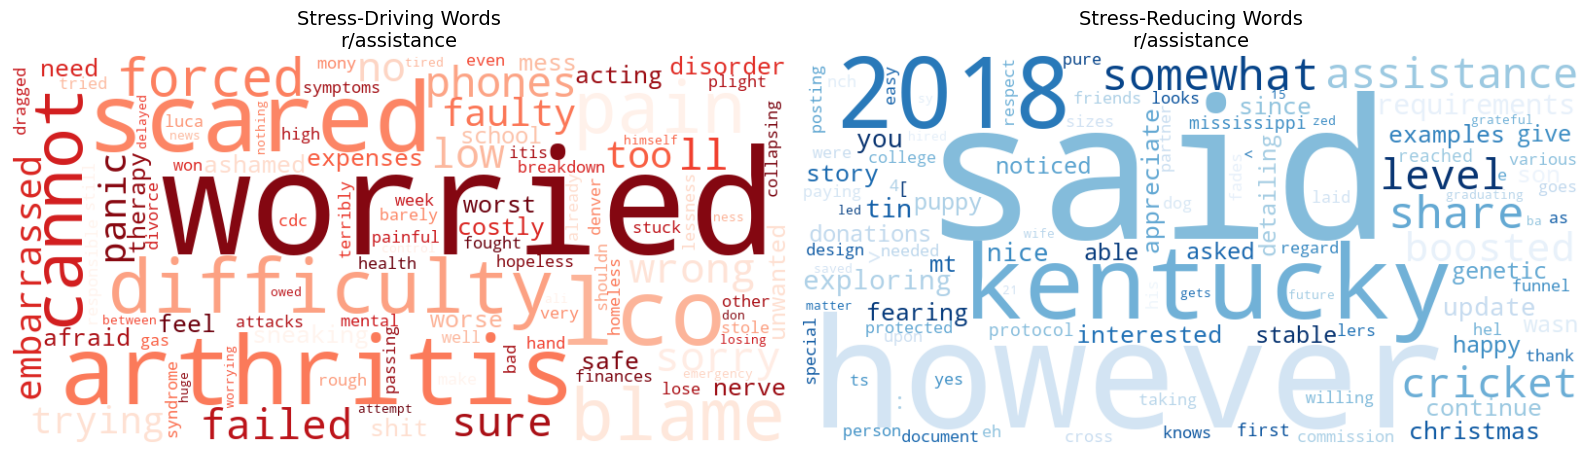

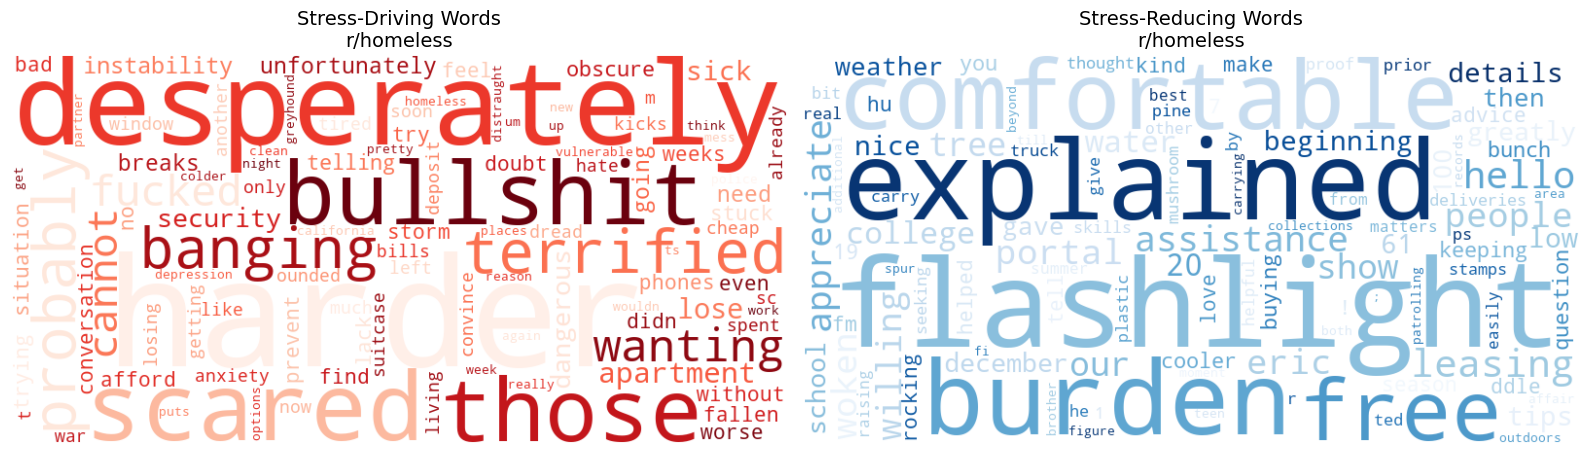

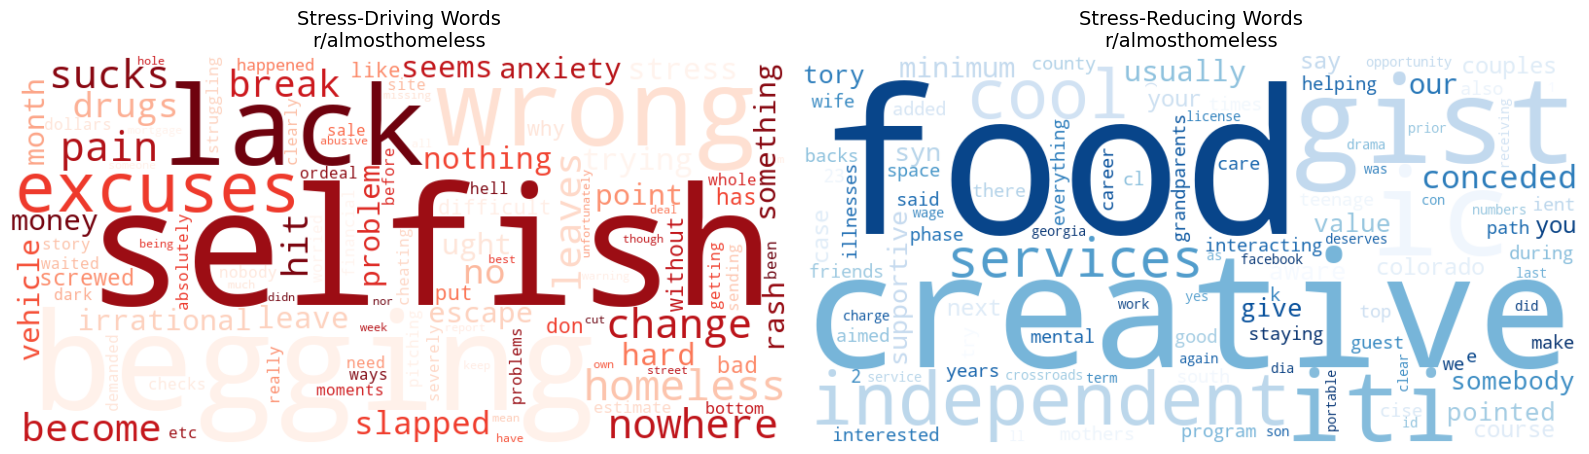

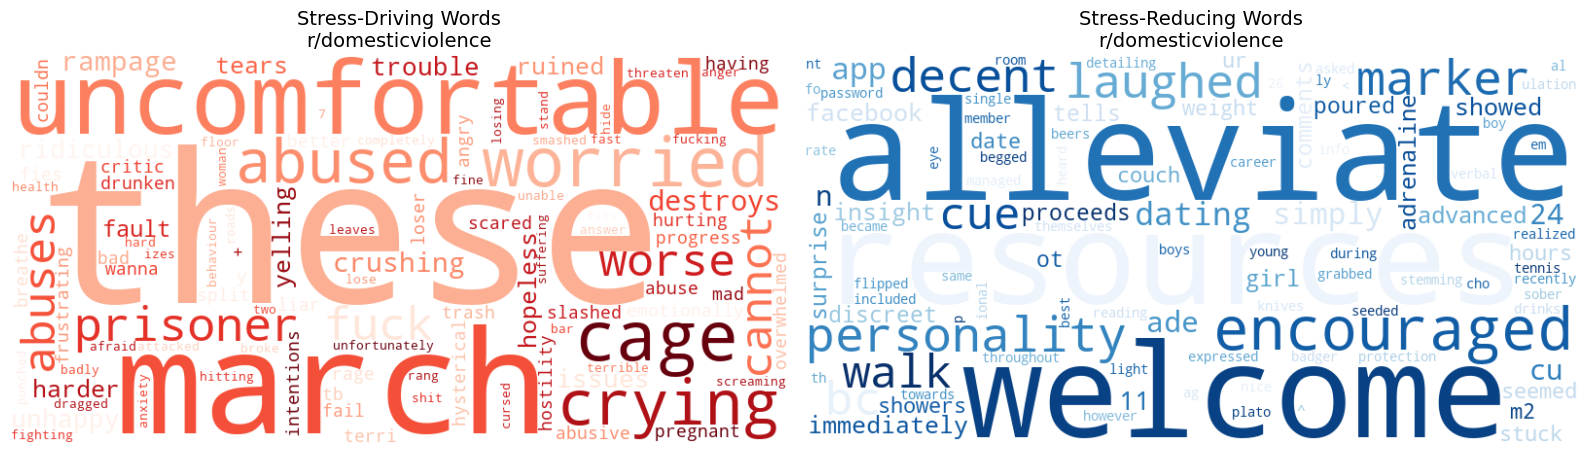

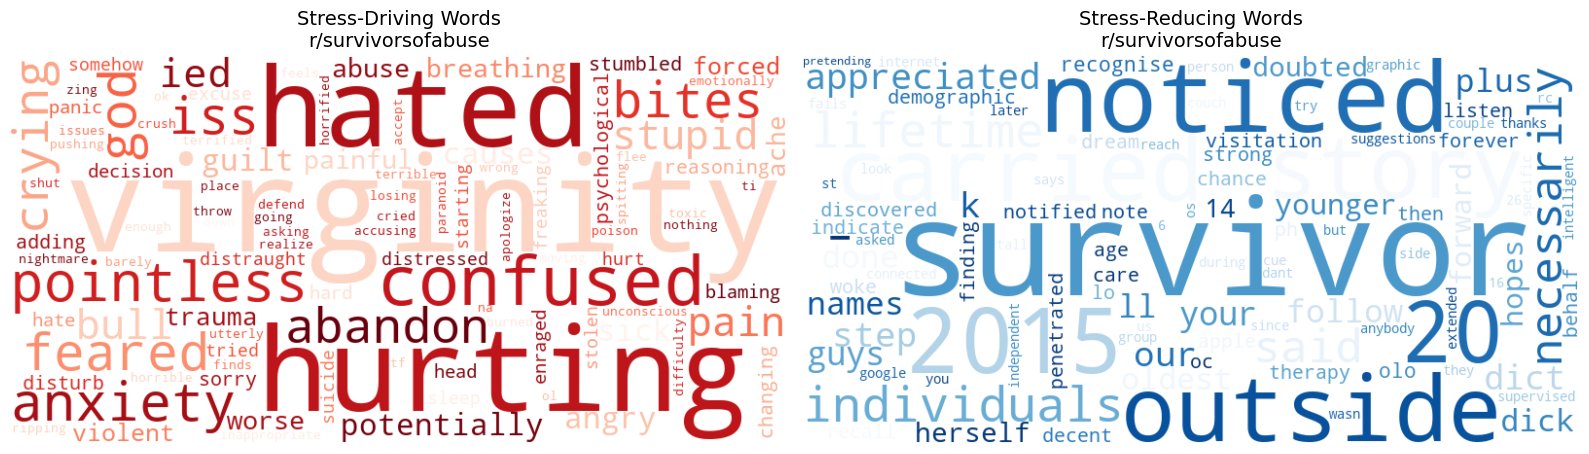

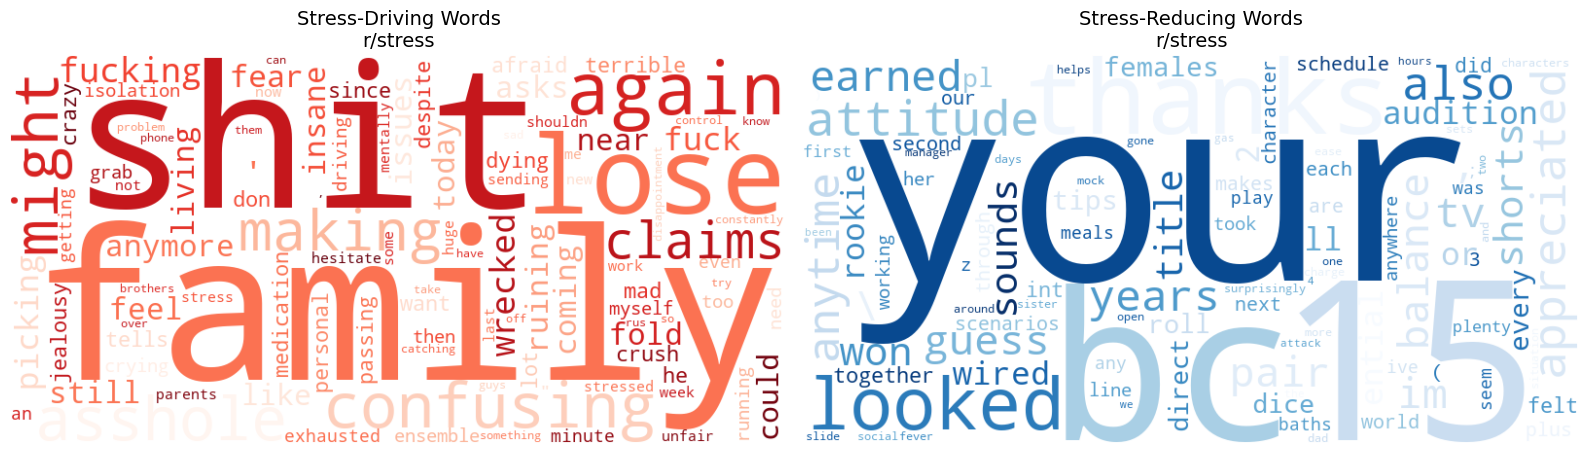

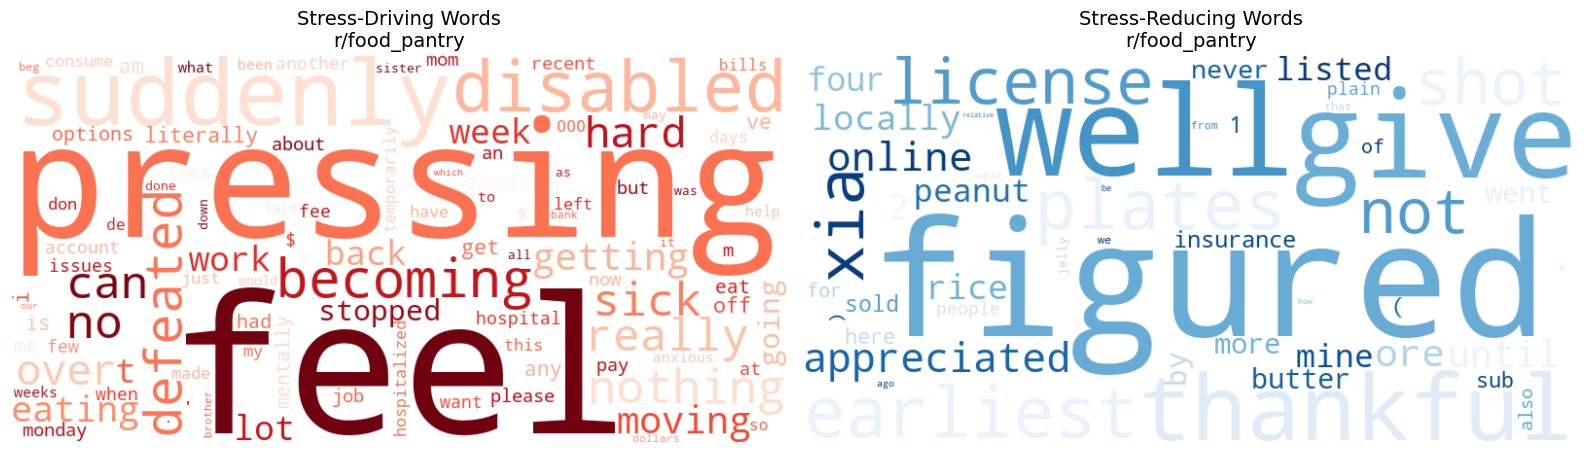

In [41]:
top_words_per_subreddit = {}

subreddits = df_test['subreddit'].unique()

for sub in subreddits:

    all_token_scores = defaultdict(list)
    
    texts = df_test[
        (df_test['subreddit'] == sub) & 
        (df_test['label'] == 1)
    ]['text'].dropna().tolist()
    
    for text in texts:
        inputs = tokenizer(text, return_tensors='pt', max_length=256)
        inputs = {k: v.to(gpu) for k, v in inputs.items()}
        
        input_embeds = model.bert.embeddings.word_embeddings(inputs['input_ids'])
        attention_mask = inputs['attention_mask']
        
        attributions = ig.attribute(
            input_embeds,
            additional_forward_args=(attention_mask,),
            target=None
        )
        
        token_scores = attributions.sum(dim=-1).squeeze(0).detach().cpu().numpy()
        tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
        
        for t, s in zip(tokens, token_scores):
            if t in ["[CLS]", "[SEP]", "[PAD]"]:
                continue
            if t.startswith("##"):
                t = t[2:]
            all_token_scores[t].append(s)
    
    # Mean attribution per token
    mean_token_scores = {t: np.mean(scores) for t, scores in all_token_scores.items()}


    positive_tokens = {t: s for t, s in mean_token_scores.items() if s > 0}
    positive_tokens = dict(sorted(positive_tokens.items(), key=lambda x: x[1], reverse=True))

    negative_tokens = {t: -s for t, s in mean_token_scores.items() if s < 0}
    negative_tokens = dict(sorted(negative_tokens.items(), key=lambda x: x[1], reverse=True))

    # Store top 20 for reporting
    top_words_per_subreddit[sub] = {
        "positive": list(positive_tokens.items())[:20],
        "negative": list(negative_tokens.items())[:20]
    }

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    if positive_tokens:
        wc_pos = WordCloud(
            width=800,
            height=400,
            background_color='white',
            colormap='Reds_r',
            max_words=100
        ).generate_from_frequencies(positive_tokens)

        axes[0].imshow(wc_pos, interpolation='bilinear')
        axes[0].set_title(f"Stress-Driving Words\nr/{sub}", fontsize=14)
        axes[0].axis('off')
    else:
        axes[0].set_title("No Positive Tokens")
        axes[0].axis('off')

    if negative_tokens:
        wc_neg = WordCloud(
            width=800,
            height=400,
            background_color='white',
            colormap='Blues_r',
            max_words=100
        ).generate_from_frequencies(negative_tokens)

        axes[1].imshow(wc_neg, interpolation='bilinear')
        axes[1].set_title(f"Stress-Reducing Words\nr/{sub}", fontsize=14)
        axes[1].axis('off')
    else:
        axes[1].set_title("No Negative Tokens")
        axes[1].axis('off')

    plt.tight_layout()
    plt.show()

From the word clouds of each subreddit, I've picked out a few words with high attributions and will discuss them below. 

**r/relationships**
- stress words: pissed, troubled, regret, struggling, disgusting, anxiety, cannot   
These words are emotionally charged and conflict-oriented. The model is correctly identifying relational stress as highly affective and conflict-driven.  

- non-stress words: preface, template, format, enjoyed, helping, excuse, bedroom    
Asides from "enjoyed" which suggests positivity, the rest of the words seem to be neutral contextual terms and structural markers.  

**r/anxiety**  
- stress words: struggled, fucked, broken, miserable, doping, panicked, freak    
Model attributes stress to emotional dysregulation vocabulary, and even intense raw language like swear words.   

- non-stress words: title, close, definitely       

**r/ptsd**  
- stress words: difficulty, terrified, affecting, forgive, stressed, failure, tried, hate, worst      
These words reflect trauma processing and fear response. "Forgive" may possibly be from trauma narratives involving guilt.   

- non-stress words: needy, hetic, core, 2017    
Some of the non-stress words don't seem to make a lot of sense, such as the year "2017", or "hetic" which isn't an actual word.   

**r/assistance**  
- stress words: worried, arthritis, difficulty, scared, pain, cannot, blame    
Words with strong health and vulnerability signals, where model has even recognized health conditions like "arthritis" as proxies for stress. This reflects domain adaptation, where the model likely understands assistance posts often link medical hardship with stress.   

- non-stress words: said, however, kentucky, somewhat, assistance, 2018

**r/homeless**  
- stress words: desperately, harder, bullshit, scared, terrified  
Model picks up urgency markers and crisis-related terms.   

- non-stress words: flashlight, explained, burden, comfortable, free  
Words that indicate helpful resources ("flashight', "comfortable"), and receival of help. The model appears to associate material aid for homelessness with reduced stress likelihood.   

**r/almosthomeless**  
- stress words: selfish, begging, lack, excuses, wrong  
These show shame, judgement and distress.   

- non-stress words: food, creative, gist, independent, services  
More neutral, context words that could indicate receival of resources ("food", "services"). Similar to findings from r/homeless.   

**r/domesticviolence**  
- stress words: these, uncomfortable, march, cage, worried, prisoner, abused, crying   
Quite a few words that refer towards feelings of entrapment and loss of autonomy, which is [common in cases of domestic violence](https://www.researchgate.net/publication/290614022_Domestic_Violence_as_a_Violation_of_Autonomy_and_Agency). Model has correctly picked up these signals of control as markers of stress in the context of domestic violence.   

- non-stress words: resources, alleviate, encouraged, welcome  
Support-oriented vocabulary push predictions towards non-stress.     

**r/survivorsofabuse**  
- stress words: virginity, hurting, hated, confused, pointless, feared, anxiety, abandon  
Model focuses on shame vocabulary. There is also quite a heavy attribution on “virginity”, potentially acting as a trauma-topic proxy as mentioned earlier.  

- non-stress words: survivor, outside, carried, noticed, story  
Model may associate an identity reclamation narrative as non-stress.  

**r/stress**
- stress words: family, shit, lose, again, confusing   
"Family" indicates that family-related strain may be a central stressor in this subreddit.  

- non-stress words: your, thanks, bc, 15, looked  
Mostly conversational filler.   

**r/food_pantry**  
- stress words: pressing, feel, suddenly, disabled, defeated, sick   
Model places emphasis on words that highlight health vulnerability and urgency, as well as time-sensitive crisis language.   

- non-stress words: figured, thankful, well, give, earliest, plates, license   
Words associated with gratitude and logistics.   


Across subreddits, IG revealed that **stress predictions by the model were driven mostly by emotionally intense and crisis-oriented vocabulary**, while **non-stress predictions were usually associated with neutral discourse markers, support-oriented language, and expressions of gratitude**.  

Importantly, the model appears sensitive not only to affective intensity but also to thematic cues specific to each community (e.g. health conditions in r/assistance and entrapment metaphors in r/domesticviolence). This suggests that the **model learned to capture context-sensitive stress semantics rather than relying on generic negativity cues**. 

## 2. Investigating cases of wrong predictions

In this section, I'll examine instances where the model produced incorrect predictions with high confidence. Specifically, I'll be analysing false negatives (stress posts predicted as non-stress) and false positives (non-stress posts predicted as stress). Here, confidence is defined as the softmax probability assigned to the predicted label. 

In [24]:
wrong = df_test[df_test["predicted"] != df_test["label"]]
wrong["confidence"].describe()

count    137.000000
mean       0.794255
std        0.131488
min        0.501603
25%        0.711574
50%        0.827247
75%        0.898975
max        0.968587
Name: confidence, dtype: float64

The mean confidence of wrong predictions is around 0.79, which is quite high. This is typical for BERT models as mentioned in [this article](https://medium.com/expedia-group-tech/calibrating-bert-based-intent-classification-models-part-2-a44752fc655a), where they often assign strong probabilities even when incorrect.

Given the high mean of 0.79, a **threshold of 0.9** was chosen to isolate the upper quartile (top 25%) of overconfident errors. This enables analysis of cases where the model assigns very high probability to incorrect classifications, which is particularly relevant given known overconfidence tendencies in BERT models.

In [25]:
confidence_threshold = 0.9

confident_mistakes = df_test[
    (df_test['predicted'] != df_test['label']) &
    (df_test['confidence'] >= confidence_threshold)
]

confident_mistakes = confident_mistakes.sort_values('confidence', ascending=False)

print(f"Found {len(confident_mistakes)} confident mistakes")

Found 34 confident mistakes


In [26]:
def clean_token(token):
    if token in ["[CLS]", "[SEP]", "[PAD]"]:
        return None
    return token

In [27]:
def get_top_tokens(text, ig, model, tokenizer, top_k=10):
    inputs = tokenizer(text, return_tensors='pt', truncation=True)
    inputs = {k: v.to(gpu) for k,v in inputs.items()}

    input_embeds = model.bert.embeddings.word_embeddings(inputs['input_ids'])
    attention_mask = inputs['attention_mask']

    attributions = ig.attribute(
        input_embeds,
        additional_forward_args=(attention_mask,),
        target=None
    )

    token_scores = attributions.sum(dim=-1).squeeze(0).detach().cpu().numpy()
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

    token_attributions = [
    (clean_token(t), s)
    for t, s in zip(tokens, token_scores)
    if clean_token(t) is not None]

    token_attributions = sorted(token_attributions, key=lambda x: abs(x[1]), reverse=True)

    return token_attributions[:top_k]

I did some cleaning and retrieving of the attribution scores once again for each individual token. Now let's proceed with the analysis.

### 2.1 Predicting stress posts as non-stress (False Negatives)

Let's take a look at some examples of FNs ('Stress' posts that have been confidently predicted to be 'Non-Stress' by the model), as well as the top 10 tokens that contributed to the model's decision-making. 

In [28]:
fn = df_test[
    (df_test['label'] == 1) & 
    (df_test['predicted'] == 0) & 
    (df_test['confidence'] >= confidence_threshold)
].sort_values('confidence', ascending=False)

print(f"Confident False Negatives: {len(fn)}\n")

for idx, row in fn.head(3).iterrows():
    print("Text:", row['text'])
    print("True label: 1 | Predicted: 0 | Confidence:", row['confidence'])
    
    top_tokens = get_top_tokens(row['text'], ig, model, tokenizer, top_k=10)
    
    print("Top tokens and attributions:")
    print("{:<15} {:>10}".format("Token", "Attribution"))
    print("-"*27)
    for t, s in top_tokens:
        print("{:<15} {:>10.3f}".format(t, s))
    
    print("-"*50)

Confident False Negatives: 11

Text: I'd like to note that I have had a couple close individuals look at my emails, evidence, etc since the last court date. I'm not that crazy, but I showed them the emails because I wanted to make sure they were real. The emails, evidence, and notes are all real. I checked my phone history, and the phone calls to the advocate and office are all logged and sufficient in length to indicate that an actual conversation occurred. I never doubted reality before the abuse, and I have never done so outside of the abuse.
True label: 1 | Predicted: 0 | Confidence: 0.9589092135429382
Top tokens and attributions:
Token           Attribution
---------------------------
abuse                0.111
done                -0.088
abuse                0.072
outside             -0.053
before              -0.051
individuals         -0.047
and                 -0.038
have                -0.038
my                   0.035
of                  -0.035
-------------------------------

For example 1:  
- “Abuse” is positively attributed, which is expected for stress detection. It also appears twice, both times with positive attribution but different importance since IG is context-aware (the same word can have different importance depending on surrounding text). There is a clear stress indicator here.    
- Negative attributions on “done”, “outside”, “individuals” and common words ("and", "of") etc. suggest that the model misinterprets parts of context as neutral or non-stress.    

Despite the post having a strong stress indicator ("abuse" with attribution score of 0.111) and the model successfully picking up on it, the cummulative effect of negative attributions from neutral contextual tokens and common words might have weakened the impact of the key stress words. The overall tone of the post is controlled and organized, and the model appears to associate this structured coherence with non-stress.  
<br/>

For example 2: 
- Surprisingly, most top tokens for this post are either neutral or punctuation.  
- Words that could potentially be related to stress (such as “divorce”, “pregnant”, “rough”) don’t appear in the top token list at all. 

The lack of explicit stress markers (unlike "abuse" in example 1) and the positive emotional context throughout the post (with the exception of the last phrase “things have been rough since the birth of our son”) could have pushed the model toward predicting non-stress. The model also elevated tokens that are structural (like punctuation tokens) rather than semantic words.  
<br/>  

For example 3:
- Most top tokens are stopwords ("the", "and", "to") or punctuation with weak semantic context despite there being clear stress indicators in the post (“money has been extraordinarily tight”, “sleep deprivation”, “fighting and bickering”). 
- Positive context was included within the post ("he is our little angel"), model picked up on positive tokens instead of the stress tokens. 

Stress here is encoded in multi-word expressions. This suggests that the model may fail to anchor on semantically meaningful stress words when stress indicators appear more in phrases than as individual tokens. When the stress signal is weakly localized across many tokens, attribution might have been spreaded across common words instead.

Essentially, the **model demonstrates sensitivity to explicit and lexically concentrated stress signals**, but shows **reduced robustness when stress is phrase-level, or embedded within balanced emotional narratives**. In such cases, attribution becomes more diffused across tokens, weakening the overall stress signal and increasing likelihood of false negatives.

In [31]:
fn_tokens = Counter()
for text in fn['text']:
    for t, s in get_top_tokens(text, ig, model, tokenizer, top_k=10):
        fn_tokens[t] += 1  

top_fn_tokens = fn_tokens.most_common(20)

print(f"{'Token':<20} {'Frequency':<10}")
print("-" * 30)
for token, freq in top_fn_tokens:
    print(f"{token:<20} {freq:<10}")

Token                Frequency 
------------------------------
.                    10        
i                    4         
abuse                3         
and                  3         
of                   3         
have                 2         
my                   2         
our                  2         
-                    2         
the                  2         
appreciate           2         
how                  2         
without              2         
,                    2         
but                  2         
done                 1         
outside              1         
before               1         
individuals          1         
since                1         


The above code shows an overall summary of how often a token appears in the top 10 tokens for false negatives. Function words and punctuation (e.g., ".", "and", "of") frequently appeared among top attributions, which is consistent with our findings from the examples above that for false negative predictions, the model seems to rely on structural cues rather than semantically meaningful stress indicators.

In [33]:
fn_pos = defaultdict(float)   # pushes toward stress
fn_neg = defaultdict(float)   # pushes toward non-stress

for text in fn['text']:
    post_pos = defaultdict(float)
    post_neg = defaultdict(float)
    
    for t, s in get_top_tokens(text, ig, model, tokenizer, top_k=10):
        if s > 0:
            post_pos[t] += s
        else:
            post_neg[t] += abs(s)

    total = sum(post_pos.values()) + sum(post_neg.values())
    for t in post_pos:
        fn_pos[t] += post_pos[t] / total
    for t in post_neg:
        fn_neg[t] += post_neg[t] / total

top_pos = sorted(fn_pos.items(), key=lambda x: x[1], reverse=True)[:20]
top_neg = sorted(fn_neg.items(), key=lambda x: x[1], reverse=True)[:20]

I aggregated token-level attributions across all false negatives, separating tokens that pushed predictions toward the stress class (positive attributions) from those that pushed toward the non-stress class (negative attributions).

top_pos shows the top tokens with the highest total stress-pushing strength across all FN posts, while top_neg shows the top tokens with the highest total non-stress-pushing strength across all FN posts. Since longer posts have more tokens and produce more total attribution, I also normalized by total attribution so that each post contributes equally.

In [34]:
top_pos

[('abuse', 0.4115806746955605),
 ('i', 0.21448779131359746),
 ('selfish', 0.19570343246428953),
 ('without', 0.17184530144498986),
 ('t', 0.16555494324010683),
 ('and', 0.1407119989783987),
 ('unfortunately', 0.14026141718260213),
 ('delayed', 0.1392745895811873),
 ('my', 0.13853894143404027),
 ('even', 0.12900915307581381),
 ('need', 0.12055084807244207),
 ('.', 0.12054330503574723),
 ('already', 0.12025600918584486),
 ('at', 0.11800787799701623),
 ('have', 0.1169265808640466),
 ('last', 0.11409223397509996),
 ('wrong', 0.10884728455340364),
 ('can', 0.10809163092342085),
 ('out', 0.10541339671764217),
 ('isolation', 0.09498007517629825)]

Top positive attributions included semantically meaningful stress-related tokens such as “abuse”, “selfish”, “wrong”, and “isolation". This indicates that the model has successfully learned to associate explicit negative vocabulary with stress. However, despite correctly identifying these stress signals, the model still predicted non-stress for these posts, suggesting that while lexical stress cues are detected, they are insufficient to override competing signals pushing the prediction toward non-stress.

In [41]:
top_neg

[('.', 0.7379531506426925),
 ('the', 0.6047821767242926),
 ('me', 0.33778479522510174),
 ('of', 0.24194945332961618),
 ('how', 0.23967072338105544),
 ('thanks', 0.20588383142722883),
 ('appreciate', 0.19511866076107734),
 ('but', 0.19473072678268497),
 ('our', 0.1665424478020624),
 ('done', 0.15472233573348962),
 (',', 0.1519872747488345),
 ('pay', 0.14785092982877013),
 ('appreciated', 0.12601247627983875),
 ('was', 0.12302077028369926),
 ('water', 0.12024689020305063),
 ('since', 0.12023263876681664),
 ('without', 0.11712767844456215),
 ('assistance', 0.10609193540117219),
 ('each', 0.10595540056309588),
 ('history', 0.10537909046645284)]

More revealing were the top negative attributions, which included punctuation and function words such as “.”, “the”, “of”, “me”, and “how”, indicating that the model could be using structural writing patterns as a proxy for detecting non-stress instead. Additionally, gratitude-related expressions such as “thanks”, “appreciate”, and “appreciated” were among the strongest contributors toward the non-stress class. The magnitude of these negative attributions was also substantially larger than the positive stress-related signals (e.g. 0.73795 for "." vs 0.41158 for "abuse").   

The model is not purely relying on semantic stress indicators but is also sensitive to stylistic patterns. In particular, structured writing appears to push predictions toward non-stress, since function words and punctuation exert disproportionate influence. This implies that the model may have learned correlations between writing style and stress labels in training. For example, if non-stress posts tend to be more structured or contain gratitude language, the model may use these features as shortcuts for classification. Consequently, stress posts written in a reflective tone or with properly structured statements may be misclassified despite containing genuine stress-related content.  

Overall, the attribution analysis reveals that **false negatives do not occur because the model fails to recognize stress vocabulary. Rather, stress-related signals are present but are overridden by stronger structural cues associated with the non-stress class.**

### 2.2 Predicting non-stress posts as stress (False Positives)

Let's take a look at some examples of FPs ('Non-Stress' posts that have been confidently predicted to be 'Stress' by the model), as well as the top 10 tokens that contributed to the model's decision-making. 

In [35]:
fp = df_test[
    (df_test['label'] == 0) & 
    (df_test['predicted'] == 1) & 
    (df_test['confidence'] >= confidence_threshold)
].sort_values('confidence', ascending=False)

print(f"Confident False Positives: {len(fp)}\n")

for idx, row in fp.head(3).iterrows():
    print("Text:", row['text'])
    print("True label: 0 | Predicted: 1 | Confidence:", row['confidence'])
    
    top_tokens = get_top_tokens(row['text'], ig, model, tokenizer, top_k=10)
    
    print("Top tokens and attributions:")
    print("{:<15} {:>10}".format("Token", "Attribution"))
    print("-"*27)
    for t, s in top_tokens:
        print("{:<15} {:>10.3f}".format(t, s))
    
    print("-"*50)

Confident False Positives: 23

Text: None of the issues we discuss get addressed. 6) After a while, I get really pissed, my significant other gets angry with me over some issue, and she ends up breaking up with me. I am weary of this whole emotional drama that I have to go through to end a relationship. I almost feel like it's not even my choice to end a relationship. Is there a way to avoid this whole process?
True label: 0 | Predicted: 1 | Confidence: 0.9685871601104736
Top tokens and attributions:
Token           Attribution
---------------------------
i                    0.039
like                 0.034
pissed               0.033
really               0.031
angry                0.030
go                   0.029
'                   -0.028
i                    0.026
feel                 0.025
s                    0.025
--------------------------------------------------
Text: He pretty much told me that he was angry and disappointed and would probably not forgive me for a while and tha

In example 1:  
- Model picked up on language indicating anger or frustration ("pissed", "angry", "really"), which is expected. 
- Importance placed on first-person narrative words ("i", "feel"). 

The model likely learned that self-referential language is correlated with stress. In this example, the post describes a situational conflict and advice seeking, rather than lamenting about ongoing stress. However, the model likely treated the intense emotional words as stress regardless of context.  
</br>

In example 2:  
- Use of strong emotion tokens ("angry", "disappointment") detected by model.  
- High weightage on self-referential tokens like "i", "me", similar to example 1.  

The negative words and situation described in the post are more reflective of someone else’s emotions (the "he" mentioned in the post) rather than the author of the post, but the model seems to treat any mention of negative interpersonal emotion and first-person narrative as stress.  
</br>

In example 3:   
- Trauma-related words ("abusive", "awful") were highly predictive of stress. Words with seemingly negative emotional outcomes ("breaks", "fearing") as well.  
- Positive words like "loving" get some negative attribution but are outweighed.  

In this example, author is describing past trauma, and the post even ends on a positive note. However, the model failed to capture temporal context here, and treated discussion of past trauma as current stress. In addition, the token "breaks" here had the highest attribution in pushing the model towards predicting as stress, but it was used in context as "breaks my heart because he’s the only person that tends to me so well", which arguably has a more positive than negative connotation. The model took it literally and wrongly identified it to be a stress contributor here. 

These examples suggest that the **model still prioritizes clear negative affective vocabulary and self-referential language, while occasionally underweighting temporal framing, narrative perspective, and pragmatic meaning**. As a result, **emotionally charged but situational, reflective, or past-oriented content may be misclassified as current stress**.

In [36]:
fp_tokens = Counter()
for text in fp['text']:
    for t, s in get_top_tokens(text, ig, model, tokenizer, top_k=10):
        fp_tokens[t] += 1 

top_fp_tokens = fp_tokens.most_common(20)

print(f"{'Token':<20} {'Frequency':<10}")
print("-" * 30)
for token, freq in top_fp_tokens:
    print(f"{token:<20} {freq:<10}")

Token                Frequency 
------------------------------
i                    22        
feel                 7         
me                   7         
'                    6         
like                 5         
t                    4         
to                   4         
don                  4         
m                    4         
so                   4         
,                    4         
.                    4         
just                 3         
’                    3         
know                 3         
wrong                3         
anxiety              3         
have                 3         
being                3         
really               2         


Let's look at the overall frequency output of the different tokens across the top 10 tokens from each false positive cases.  

Self-referential pronouns dominate (especially "i" with 22 appearances), indicating that the model heavily associates first-person narratives with stress. Tokens that capture emotional state ("anxiety") were also picked up by the model. Essentially, it seems like the model has learned a heuristic whereby “first-person + emotional language = stress”. 

In [37]:
fp_pos = defaultdict(float)   # pushes toward stress
fp_neg = defaultdict(float)   # pushes toward non-stress

for text in fp['text']:
    post_pos = defaultdict(float)
    post_neg = defaultdict(float)
    
    for t, s in get_top_tokens(text, ig, model, tokenizer, top_k=10):
        if s > 0:
            post_pos[t] += s
        else:
            post_neg[t] += abs(s)

    total = sum(post_pos.values()) + sum(post_neg.values())
    if total > 0:  
        for t in post_pos:
            fp_pos[t] += post_pos[t] / total
        for t in post_neg:
            fp_neg[t] += post_neg[t] / total

top_fp_pos = sorted(fp_pos.items(), key=lambda x: x[1], reverse=True)[:20]
top_fp_neg = sorted(fp_neg.items(), key=lambda x: x[1], reverse=True)[:20]

Similar to what I did for the false negatives, here I obtain the normalized per-post attribution aggregation for false positives.  

top_fp_pos gives me the top tokens that strongly push the model toward stress in posts that are actually non-stress. top_fp_neg gives me the top tokens that push the model back toward non-stress.

In [38]:
top_fp_pos

[('i', 2.0940691716382775),
 ('feel', 0.7289121845675588),
 ('t', 0.6069426517082661),
 ('like', 0.5919200794708519),
 ('anxiety', 0.495752940777326),
 ("'", 0.4284444481206159),
 ('me', 0.4243670340030376),
 ('m', 0.38749480199274156),
 ('don', 0.3726573823837059),
 ('so', 0.36893217804964606),
 ('to', 0.33955106034954563),
 ('awful', 0.33773180296131794),
 ('.', 0.32292764076294156),
 ('hurt', 0.31922118888901485),
 (',', 0.2679449928169607),
 ('have', 0.2586157684962145),
 ('angry', 0.25220759853769614),
 ('wrong', 0.24472224092893724),
 ('homeless', 0.2411938071281289),
 ('just', 0.23675681466612858)]

Among the top tokens that pushes the model towards predicting stress, self-referential pronouns dominate ("i", "me", "feel") appear frequently. Negative words like "awful", "anxiety", "hurt" and "homeless" also played a part in strongly pushing towards stress prediction. This is consistent from what we've seen in the examples above as well. 

In [39]:
top_fp_neg

[(',', 0.3656178347218968),
 ('change', 0.22307617507054675),
 ('would', 0.19309700845070038),
 ('first', 0.17836635898234307),
 ('planted', 0.15147540436479073),
 ('’', 0.14346584993195702),
 ('the', 0.11122476955196789),
 ('##ew', 0.10533847299093432),
 ('.', 0.09826051245195717),
 ("'", 0.09421263809412668),
 ('a', 0.08956908425791617),
 ('loving', 0.08494218687177164),
 ('me', 0.08180315173765544),
 ('begin', 0.07305236835934269),
 ('that', 0.07219565172982322),
 ('not', 0.07100969169096653),
 ('reached', 0.07091205332999212),
 ('do', 0.07012289308064183),
 ('best', 0.0693533070535273),
 ('friends', 0.0662512226263975)]

Among top tokens that influences the model towards predicting as non-stress, there are quite a few positive tokens like "loving", "best", "friends". There are also quite some neutral words and punctuation. 

Comparing both results, it seems like there is an over-reliance on self-reference tokens by the model, where these tokens dominate the positive attribution scores. The normalized attribution score for "i" is also much higher (at around 2) than any other token, implying that **posts with plenty of self-reference will likely be wrongly predicted to be stress**, since the contributions of most other tokens towards predicting non-stress would be minimized. 


### 2.3 Diving further into False Negatives - comparing them against True Positive cases 
In this subsection, I will further investigate why the model is missing out on identifying these FN cases as 'Stress' posts.

I will be refering to false negative posts as FN and true positive posts as TP for abbreviation.   
FN: Posts that are actually labelled as 'Stress' but wrongly classified to be 'Non-Stress' by the model  
TP: Posts that are actually labelled as 'Stress' and also correctly classified to be 'Stress' by the model  

In [40]:
fn = df_test[(df_test["label"] == 1) & (df_test["predicted"] == 0)]
tp = df_test[(df_test["label"] == 1) & (df_test["predicted"] == 1)]

print("FN:", len(fn))
print("TP:", len(tp))

FN: 48
TP: 321


I group the lexical features from the test dataset into different categories for a more comprehensive analysis. Most of the categories were derived from this [LIWC paper](https://www.liwc.app/static/documents/LIWC-22%20Manual%20-%20Development%20and%20Psychometrics.pdf).

Specifically, I'll be looking at lexical features of these categories: Summary (LIWC summary variables including tone, authenticity etc.), Function Words (pronouns, verbs etc.), Affect (emotional words), Social (words involving references to others), Cognitive (words that show insight), Perceptual (words related to describing senses and perception), Drives (power, affliation-related words), Time (past/present/future references), Informal (informal speech), Punctuation, and overall Sentiment. 

In [43]:
feature_groups = {
    "summary": [
        "lex_liwc_Analytic",
        "lex_liwc_Clout",
        "lex_liwc_Authentic",
        "lex_liwc_Tone"
    ],

    "linguistic_function_words": [
        "lex_liwc_function",
        "lex_liwc_pronoun",
        "lex_liwc_ppron",
        "lex_liwc_i",
        "lex_liwc_we",
        "lex_liwc_you",
        "lex_liwc_shehe",
        "lex_liwc_they",
        "lex_liwc_ipron",
        "lex_liwc_article",
        "lex_liwc_prep",
        "lex_liwc_auxverb",
        "lex_liwc_adverb",
        "lex_liwc_conj",
        "lex_liwc_negate",
        "lex_liwc_verb",
        "lex_liwc_adj",
        "lex_liwc_compare",
        "lex_liwc_interrog",
        "lex_liwc_number",
        "lex_liwc_quant",
    ],

    "affect": [
        "lex_liwc_affect",
        "lex_liwc_posemo",
        "lex_liwc_negemo",
        "lex_liwc_anx",
        "lex_liwc_anger",
        "lex_liwc_sad",
    ],

    "social": [
        "lex_liwc_social",
        "lex_liwc_family",
        "lex_liwc_friend",
        "lex_liwc_female",
        "lex_liwc_male",
    ],

    "cognitive": [
        "lex_liwc_cogproc",
        "lex_liwc_insight",
        "lex_liwc_cause",
        "lex_liwc_discrep",
        "lex_liwc_tentat",
        "lex_liwc_certain",
        "lex_liwc_differ",
    ],

    "perceptual": [
        "lex_liwc_percept",
        "lex_liwc_see",
        "lex_liwc_hear",
        "lex_liwc_feel",
    ],

    "drives": [
        "lex_liwc_drives",
        "lex_liwc_affiliation",
        "lex_liwc_achieve",
        "lex_liwc_power",
    ],

    "time_orientation": [
        "lex_liwc_focuspast",
        "lex_liwc_focuspresent",
        "lex_liwc_focusfuture",
    ],

    "informal": [
        "lex_liwc_informal",
        "lex_liwc_swear",
        "lex_liwc_netspeak",
        "lex_liwc_assent",
        "lex_liwc_nonflu",
        "lex_liwc_filler",
    ],

    "punctuation": [
        "lex_liwc_AllPunc",
        "lex_liwc_Period",
        "lex_liwc_Comma",
        "lex_liwc_Colon",
        "lex_liwc_SemiC",
        "lex_liwc_QMark",
        "lex_liwc_Exclam",
        "lex_liwc_Dash",
        "lex_liwc_Quote",
        "lex_liwc_Apostro",
        "lex_liwc_Parenth",
        "lex_liwc_OtherP",
    ],

    "sentiment": [
        "sentiment",
    ]
}

In [41]:
def compare_groups(fn, tp, feature_groups):
    results = []

    for group_name, features in feature_groups.items():
        # Mean values
        fn_mean = fn[features].mean()
        tp_mean = tp[features].mean()
        
        # Pooled std for Cohen's d
        fn_std = fn[features].std()
        tp_std = tp[features].std()
        pooled_std = np.sqrt((fn_std**2 + tp_std**2) / 2)
        
        # Avoid division by zero
        pooled_std = pooled_std.replace(0, np.nan)
        
        cohens_d = (fn_mean - tp_mean) / pooled_std
        
        # T-test
        p_values = []
        for f in features:
            stat, p = ttest_ind(fn[f], tp[f], equal_var=False, nan_policy='omit')
            p_values.append(p)
        
        group_df = pd.DataFrame({
            "feature": features,
            "FN_mean": fn_mean.values,
            "TP_mean": tp_mean.values,
            "mean_diff (FN-TP)": (fn_mean - tp_mean).values,
            "cohens_d": cohens_d.values,
            "p_value": p_values,
            "group": group_name
        })
        
        results.append(group_df)

    return pd.concat(results, ignore_index=True)

I used Cohen's d (a standardized effect size for measuring the difference between two group means) to compare the differences in lexical features between the FN and TP cases. 

The p-value measure here refers to the probability that the difference in means between FN and TP for a particular feature could have occurred by random chance if their true means were actually equal (i.e. it will only be meaningful to compare the feature if the p-value is very small). I use 0.05 (the standard level in statistical analysis) as the threshold value, and will only look at comparing features where the p-value falls under 0.05 and are hence statistically significant for comparison.   

The Cohen's d value is then used to measure the effect size (how large the difference is in standardized units). A larger absolute value of Cohen's d indicates a more substantial difference between FN and TP groups for that feature.  

In [46]:
comparison_df = compare_groups(fn, tp, feature_groups)

comparison_df_sorted = (
    comparison_df
    .assign(abs_d = comparison_df["cohens_d"].abs())
)

#### Summary Variables

In [48]:
comparison_df_sorted[
    comparison_df_sorted["feature"].isin(feature_groups["summary"])
].sort_values("abs_d", ascending=False) \
 .drop(columns="abs_d")

feature    FN_mean    TP_mean  mean_diff (FN-TP)  cohens_d  \
3       lex_liwc_Tone  33.109167  12.694860          20.414307  0.790463   
1      lex_liwc_Clout  46.597292  25.220218          21.377074  0.776495   
0   lex_liwc_Analytic  39.438750  28.810592          10.628158  0.448643   
2  lex_liwc_Authentic  68.168333  78.435047         -10.266713 -0.358527   

    p_value    group  
3  0.000030  summary  
1  0.000017  summary  
0  0.004499  summary  
2  0.029989  summary

The strongest difference lies in lex_liwc_Tone, followed by lex_liwc_Clout (Cohen's d value of 0.79 and 0.77 respectively). **FNs carry a more positive emotional tone, as well as stronger language of leadership/status**. From lex_liwc_Analytic and lex_liwc_Authentic, although less significant, **FNs also contains language reflecting more analytical thinking, while TP posts scored higher in perceived honesty and genuineness.**

#### Linguistic Dimensions

In [40]:
comparison_df_sorted[
    comparison_df_sorted["feature"].isin(feature_groups["linguistic_function_words"])
].sort_values("abs_d", ascending=False) \
 .drop(columns="abs_d")

feature    FN_mean    TP_mean  mean_diff (FN-TP)  cohens_d  \
7          lex_liwc_i   8.611458  11.128349          -2.516891 -0.655258   
17      lex_liwc_conj   6.910417   8.385016          -1.474599 -0.551581   
8         lex_liwc_we   1.422292   0.449720           0.972572  0.485522   
13   lex_liwc_article   5.511458   4.346916           1.164542  0.452529   
4   lex_liwc_function  57.950417  60.317695          -2.367278 -0.433019   
19      lex_liwc_verb  18.176667  19.853614          -1.676947 -0.378599   
16    lex_liwc_adverb   5.712708   6.663458          -0.950750 -0.343710   
23    lex_liwc_number   1.507917   1.074143           0.433773  0.289215   
18    lex_liwc_negate   2.069375   2.604237          -0.534862 -0.284011   
24     lex_liwc_quant   2.716458   2.219283           0.497175  0.246808   
10     lex_liwc_shehe   3.341458   2.491807           0.849651  0.230226   
15   lex_liwc_auxverb  10.017708  10.604143          -0.586435 -0.158882   
5    lex_liwc_pronoun  19.903125  20.793645          -0.890520 -0.156928   
21   lex_liwc_compare   2.652708   2.412150           0.240559  0.139166   
6      lex_liwc_ppron  14.276250  14.829751          -0.553501 -0.110755   
14      lex_liwc_prep  13.723125  13.346044           0.377081  0.107488   
22  lex_liwc_interrog   1.416042   1.569065          -0.153024 -0.105866   
12     lex_liwc_ipron   5.626875   5.941931          -0.315056 -0.100232   
9        lex_liwc_you   0.422500   0.343863           0.078637  0.075083   
11      lex_liwc_they   0.478958   0.415763           0.063195  0.062980   
20       lex_liwc_adj   4.543125   4.604393          -0.061268 -0.023407   

     p_value                      group  
7   0.000157  linguistic_function_words  
17  0.000333  linguistic_function_words  
8   0.012253  linguistic_function_words  
13  0.005242  linguistic_function_words  
4   0.005726  linguistic_function_words  
19  0.014016  linguistic_function_words  
16  0.015683  linguistic_function_words  
23  0.071543  linguistic_function_words  
18  0.073344  linguistic_function_words  
24  0.144383  linguistic_function_words  
10  0.157679  linguistic_function_words  
15  0.292769  linguistic_function_words  
5   0.337080  linguistic_function_words  
21  0.325380  linguistic_function_words  
6   0.502109  linguistic_function_words  
14  0.478279  linguistic_function_words  
22  0.452141  linguistic_function_words  
12  0.504387  linguistic_function_words  
9   0.616760  linguistic_function_words  
11  0.673054  linguistic_function_words  
20  0.875410  linguistic_function_words

Let's look at lex_liwc_i, lex_liwc_conj and lex_liwc_we first. Self-focus seems to be a strong differentiator between the 2 categories: **TP posts use more first person singular pronouns (like "I", "me", "my", "myself")  while FN posts have much higher first person plural pronoun usage ("we", "our", "us", "lets"). TPs also use more conjunctions (like "and", "but", "so")**.  

Now we look at lex_liwc_article, lex_liwc_function, lex_liwc_verb and lex_liwc_adverb. **FN posts seem to use slightly more articles ("a", "an", "the"), but less overall function words ("the", "to", "and"), verbs and adverbs.**

The remaining linguistic dimensions have small effects and are mostly non-significant.

#### Drives

In [41]:
comparison_df_sorted[
    comparison_df_sorted["feature"].isin(feature_groups["drives"])
].sort_values("abs_d", ascending=False) \
 .drop(columns="abs_d")

feature   FN_mean   TP_mean  mean_diff (FN-TP)  cohens_d  \
53  lex_liwc_affiliation  3.549375  1.818006           1.731369  0.563401   
52       lex_liwc_drives  8.452500  6.927913           1.524587  0.387648   
54      lex_liwc_achieve  1.135625  1.266012          -0.130387 -0.100891   
55        lex_liwc_power  2.576667  2.378847           0.197819  0.095913   

     p_value   group  
53  0.002926  drives  
52  0.026147  drives  
54  0.470587  drives  
55  0.568764  drives

**FN posts mention affliations (through words like "we", "our", "us") more often**, and hence a higher scoring on drives overall. 

#### Cognition

In [42]:
comparison_df_sorted[
    comparison_df_sorted["feature"].isin(feature_groups["cognitive"])
].sort_values("abs_d", ascending=False) \
 .drop(columns="abs_d")

feature    FN_mean    TP_mean  mean_diff (FN-TP)  cohens_d  \
37  lex_liwc_insight   2.322083   2.907757          -0.585674 -0.291669   
36  lex_liwc_cogproc  12.700833  14.171308          -1.470475 -0.275091   
40   lex_liwc_tentat   2.902500   3.462025          -0.559525 -0.211926   
42   lex_liwc_differ   3.788125   4.284361          -0.496236 -0.187481   
41  lex_liwc_certain   1.482083   1.696667          -0.214583 -0.132439   
39  lex_liwc_discrep   1.528333   1.743583          -0.215249 -0.132196   
38    lex_liwc_cause   1.626667   1.831807          -0.205140 -0.108193   

     p_value      group  
37  0.037502  cognitive  
36  0.076987  cognitive  
40  0.173285  cognitive  
42  0.224031  cognitive  
41  0.387947  cognitive  
39  0.376741  cognitive  
38  0.499652  cognitive

Only lex_liwc_insight is significant. **TP posts tend to use slightly more words that indicate insight (such as "know", "how", "think", "feel") than FNs**. 

#### Affect

In [43]:
comparison_df_sorted[
    comparison_df_sorted["feature"].isin(feature_groups["affect"])
].sort_values("abs_d", ascending=False) \
 .drop(columns="abs_d")

feature   FN_mean   TP_mean  mean_diff (FN-TP)  cohens_d  \
27  lex_liwc_negemo  2.653333  4.798598          -2.145265 -0.820174   
28     lex_liwc_anx  0.779792  1.546573          -0.766782 -0.455089   
25  lex_liwc_affect  5.096250  6.555826          -1.459576 -0.453561   
26  lex_liwc_posemo  2.366042  1.682555           0.683487  0.394175   
29   lex_liwc_anger  0.713125  1.218318          -0.505193 -0.376408   
30     lex_liwc_sad  0.486667  0.871931          -0.385265 -0.370963   

         p_value   group  
27  1.082391e-07  affect  
28  1.801891e-03  affect  
25  4.515112e-03  affect  
26  1.756987e-02  affect  
29  6.946994e-03  affect  
30  9.748518e-03  affect

The strongest difference lies in the lex_liwc_negemo feature. **TPs contain much more negative emotion language**. From lex_liwc_anx, lex_liwc_affect, lex_liwc_anger and lex_liwc_sad, **TP posts seem to describe higher levels of anxiety, anger, sadness, and overall affect**, making them more emotionally explicit.  
On the other hand, **FN posts actually have slightly more positive emotion language** than TP.

#### Social Processes

In [44]:
comparison_df_sorted[
    comparison_df_sorted["feature"].isin(feature_groups["social"])
].sort_values("abs_d", ascending=False) \
 .drop(columns="abs_d")

feature    FN_mean   TP_mean  mean_diff (FN-TP)  cohens_d  \
34  lex_liwc_female   2.908125  1.253115           1.655010  0.516688   
31  lex_liwc_social  11.572500  8.533302           3.039198  0.488256   
35    lex_liwc_male   1.261042  2.000654          -0.739613 -0.284994   
33  lex_liwc_friend   0.672083  0.480654           0.191429  0.204433   
32  lex_liwc_family   0.787083  0.656355           0.130728  0.107312   

     p_value   group  
34  0.004971  social  
31  0.002541  social  
35  0.028827  social  
33  0.192946  social  
32  0.494100  social

**FN posts reference women-related pronouns more frequently and are overall more socially descriptive** (with the use of a variety of pronouns like "you", "we", "he", "she"). On the contrary, **TP posts reference men more often**.  
lex_liwc_friend and lex_liwc_family (i.e. mentions of family and relationship terms), surprisingly, have small or negligible significance. 

#### Perception

In [45]:
comparison_df_sorted[
    comparison_df_sorted["feature"].isin(feature_groups["perceptual"])
].sort_values("abs_d", ascending=False) \
 .drop(columns="abs_d")

feature   FN_mean   TP_mean  mean_diff (FN-TP)  cohens_d  \
46     lex_liwc_feel  0.645625  1.334953          -0.689328 -0.567999   
43  lex_liwc_percept  1.943542  2.488754          -0.545212 -0.314968   
44      lex_liwc_see  0.530625  0.427227           0.103398  0.129777   
45     lex_liwc_hear  0.601667  0.516854           0.084813  0.084375   

     p_value       group  
46  0.000025  perceptual  
43  0.028812  perceptual  
44  0.412153  perceptual  
45  0.593928  perceptual

As seen from lex_liwc_feel and lex_liwc_percept, **TP posts use more “feel” words and are more explicit in describing internal states and perception**.

#### Temporal Features

In [48]:
comparison_df_sorted[
    comparison_df_sorted["feature"].isin(feature_groups["time_orientation"])
].sort_values("abs_d", ascending=False) \
 .drop(columns="abs_d")

feature   FN_mean    TP_mean  mean_diff (FN-TP)  cohens_d  \
59  lex_liwc_focuspresent  9.039583  13.353925          -4.314342 -0.796362   
58     lex_liwc_focuspast  7.010000   4.703022           2.306978  0.560340   
60   lex_liwc_focusfuture  0.794167   1.117913          -0.323746 -0.266897   

     p_value             group  
59  0.000001  time_orientation  
58  0.001500  time_orientation  
60  0.086772  time_orientation

**TPs are much more present-focused (words like "is", "are", "I’m", "can") while FNs are more past-focused (e.g. "was", "had", "were")**. 

#### Informal Language

In [50]:
comparison_df_sorted[
    comparison_df_sorted["feature"].isin(feature_groups["informal"])
].sort_values("abs_d", ascending=False) \
 .drop(columns="abs_d")

feature   FN_mean   TP_mean  mean_diff (FN-TP)  cohens_d  \
72     lex_liwc_swear  0.200417  0.396262          -0.195845 -0.294805   
75    lex_liwc_nonflu  0.045417  0.103988          -0.058571 -0.208290   
71  lex_liwc_informal  0.650000  0.853801          -0.203801 -0.201644   
74    lex_liwc_assent  0.188958  0.101994           0.086965  0.201480   
76    lex_liwc_filler  0.012917  0.053053          -0.040136 -0.175008   
73  lex_liwc_netspeak  0.189167  0.158816           0.030350  0.056445   

     p_value     group  
72  0.013647  informal  
75  0.078331  informal  
71  0.123157  informal  
74  0.246264  informal  
76  0.065180  informal  
73  0.710444  informal

From lex_liwc_swear, **TP posts use more swear words**.  

#### Punctuation

In [51]:
comparison_df_sorted[
    comparison_df_sorted["feature"].isin(feature_groups["punctuation"])
].sort_values("abs_d", ascending=False) \
 .drop(columns="abs_d")

feature    FN_mean    TP_mean  mean_diff (FN-TP)  cohens_d  \
84     lex_liwc_Dash   1.776458   0.326231           1.450228  0.288051   
79    lex_liwc_Comma   3.817500   3.099408           0.718092  0.272961   
77  lex_liwc_AllPunc  17.535625  15.801277           1.734348  0.222494   
80    lex_liwc_Colon   0.210208   0.113645           0.096563  0.200633   
87  lex_liwc_Parenth   0.917917   0.599875           0.318041  0.199253   
86  lex_liwc_Apostro   3.164167   3.722305          -0.558139 -0.193942   
85    lex_liwc_Quote   0.585000   0.373925           0.211075  0.173404   
83   lex_liwc_Exclam   0.145000   0.075234           0.069766  0.149722   
88   lex_liwc_OtherP   0.407708   0.618879          -0.211170 -0.126722   
82    lex_liwc_QMark   0.400833   0.550280          -0.149447 -0.123129   
78   lex_liwc_Period   5.999792   6.207103          -0.207311 -0.071979   
81    lex_liwc_SemiC   0.110625   0.115016          -0.004391 -0.008830   

     p_value        group  
84  0.161201  punctuation  
79  0.083909  punctuation  
77  0.202436  punctuation  
80  0.252353  punctuation  
87  0.267055  punctuation  
86  0.196960  punctuation  
85  0.305312  punctuation  
83  0.374609  punctuation  
88  0.312787  punctuation  
82  0.426307  punctuation  
78  0.618792  punctuation  
81  0.944815  punctuation

Punctuation is an interesting one. Back in earlier sections, I found that punctuations had relatively high IG attribution scores (i.e. greater contribution towards model predictions) for FN cases. However, here it seems like FN and TP posts don’t differ strongly in punctuation usage. 

This is a reminder that feature attribution (IG) doesn’t always correlate with mean differences, so even if FN posts don’t on average have more punctuation usage, specific FNs may have used punctuation in ways that misled the model.

In [53]:
comparison_df_sorted[
    comparison_df_sorted["feature"].isin(feature_groups["sentiment"])
].sort_values("abs_d", ascending=False) \
 .drop(columns="abs_d")

feature   FN_mean   TP_mean  mean_diff (FN-TP)  cohens_d   p_value  \
91  sentiment  0.074389 -0.027676           0.102065  0.646213  0.000011   

        group  
91  sentiment

Based off the sentiment score from the Pattern sentiment library, **FNs had slightly more positive sentiment on average**, which aligns with the previous findings we saw from Summary Variables and Affect sections. 

All the above comparisons across different features between TPs and FNs highlights that the model may be reliant on certain cues (e.g. negative sentiment, use of first person singular pronouns etc.) and hence misses some actual 'Stress' posts in the test dataset, especially when these missed posts deviate slightly from the commmon features observed in usual 'Stress' posts. 

## 3. Ease of prediction: Which subreddits are easier to predict

Previously, we've looked at the words contributing the most to stress prediction on a subreddit level in section 1. Now, I want to further analyze which subreddits has posts that are easier for stress prediction and speculate on why.  

Firstly, I want to see how well the model performs per subreddit so far.

In [84]:
sr_perf = (
    df_test.groupby("subreddit")
    .apply(lambda g: pd.Series({
        "accuracy": (g.predicted == g.label).mean(),
        "f1": f1_score(g.label, g.predicted),
        "mean_conf_correct": g[g.predicted == g.label].confidence.mean(),
        "n_samples": len(g)
    }))
    .reset_index()
    .sort_values("f1", ascending=False)
)

sr_perf

subreddit  accuracy        f1  mean_conf_correct  n_samples
4       food_pantry  1.000000  1.000000           0.863304        6.0
8            stress  0.857143  0.900000           0.920057       14.0
1           anxiety  0.843537  0.871508           0.885745      147.0
3  domesticviolence  0.819444  0.863158           0.847817       72.0
6              ptsd  0.803150  0.852071           0.902857      127.0
2        assistance  0.893939  0.829268           0.908558       66.0
0    almosthomeless  0.789474  0.818182           0.869615       19.0
9  survivorsofabuse  0.800000  0.805556           0.836685       70.0
7     relationships  0.753521  0.728682           0.872600      142.0
5          homeless  0.730769  0.695652           0.874238       52.0

From the above table, we can see that the number of posts from each subreddit in the test dataset varies from 6 to 147, which is a very big difference. Because of the difference in sample sizes, a high F1 score on very small subreddits (such as food_pantry) can be unreliable, and large subreddits with slightly lower F1 may actually be more trustworthy. 

Instead of looking at the raw f1 scores for comparison, I will re-define an 'easy' subreddit to predict for as one that is both well-predicted and has enough data for that result to be meaningful. I calculate a self-defined 'ease score' using this formula `F1 × log(n_samples)`, where the logarithmic transformation helps in penalizing subreddits with a very small number of post samples while preventing those with larger number of samples from dominating the score.

I then normalize the ease scores with min–max normalization to keep the possible values between 0 and 1 for easier comparison, with 0 indicating lowest relative ease and 1 meaning highest relative ease of prediction. 



In [ ]:
sr_perf["ease_score"] = sr_perf["f1"] * np.log(sr_perf["n_samples"])
sr_perf["ease_norm"] = (sr_perf["ease_score"] - sr_perf["ease_score"].min()) / (sr_perf["ease_score"].max() - sr_perf["ease_score"].min())

In [86]:
sr_perf

subreddit  accuracy        f1  mean_conf_correct  n_samples  \
4       food_pantry  1.000000  1.000000           0.863304        6.0   
8            stress  0.857143  0.900000           0.920057       14.0   
1           anxiety  0.843537  0.871508           0.885745      147.0   
3  domesticviolence  0.819444  0.863158           0.847817       72.0   
6              ptsd  0.803150  0.852071           0.902857      127.0   
2        assistance  0.893939  0.829268           0.908558       66.0   
0    almosthomeless  0.789474  0.818182           0.869615       19.0   
9  survivorsofabuse  0.800000  0.805556           0.836685       70.0   
7     relationships  0.753521  0.728682           0.872600      142.0   
5          homeless  0.730769  0.695652           0.874238       52.0   

   ease_score  ease_norm  
4    1.791759   0.000000  
8    2.375152   0.228115  
1    4.349204   1.000000  
3    3.691438   0.742804  
6    4.127591   0.913346  
2    3.474348   0.657918  
0    2.409086   0.241384  
9    3.422399   0.637605  
7    3.611223   0.711438  
5    2.748691   0.374175

From observation, there are 2 natural breaks in the ease_norm score: between 0.374 to 0.638, and between 0.743 to 0.913.  

That suggests three ease-of-prediction categories to group the subreddits into: 
- Hard: ease_norm < 0.40
- Moderate: 0.40 =< ease_norm < 0.75
- Easy : ease_norm >= 0.75

In [87]:
def categorize_difficulty(score):
    if score >= 0.75:
        return "Easy"
    elif score >= 0.40:
        return "Moderate"
    else:
        return "Hard"

sr_perf["difficulty"] = sr_perf["ease_norm"].apply(categorize_difficulty)
sr_perf

subreddit  accuracy        f1  mean_conf_correct  n_samples  \
4       food_pantry  1.000000  1.000000           0.863304        6.0   
8            stress  0.857143  0.900000           0.920057       14.0   
1           anxiety  0.843537  0.871508           0.885745      147.0   
3  domesticviolence  0.819444  0.863158           0.847817       72.0   
6              ptsd  0.803150  0.852071           0.902857      127.0   
2        assistance  0.893939  0.829268           0.908558       66.0   
0    almosthomeless  0.789474  0.818182           0.869615       19.0   
9  survivorsofabuse  0.800000  0.805556           0.836685       70.0   
7     relationships  0.753521  0.728682           0.872600      142.0   
5          homeless  0.730769  0.695652           0.874238       52.0   

   ease_score  ease_norm difficulty  
4    1.791759   0.000000       Hard  
8    2.375152   0.228115       Hard  
1    4.349204   1.000000       Easy  
3    3.691438   0.742804   Moderate  
6    4.127591   0.913346       Easy  
2    3.474348   0.657918   Moderate  
0    2.409086   0.241384       Hard  
9    3.422399   0.637605   Moderate  
7    3.611223   0.711438   Moderate  
5    2.748691   0.374175       Hard

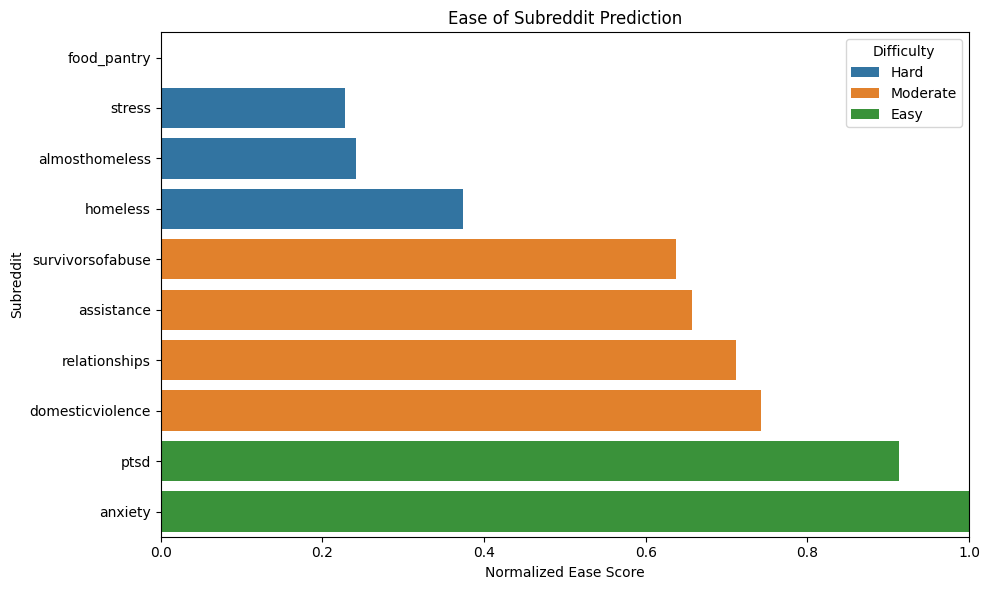

In [ ]:
sr_sorted = sr_perf.sort_values("ease_norm", ascending=True)

plt.figure(figsize=(10,6))

sns.barplot(
    data=sr_sorted,
    x="ease_norm",
    y="subreddit",
    hue="difficulty",
    dodge=False
)

plt.xlabel("Normalized Ease Score")
plt.ylabel("Subreddit")
plt.title("Ease of Subreddit Prediction")
plt.xlim(0,1)

plt.legend(title="Difficulty")
plt.tight_layout()
plt.show()

Using the normalized ease score (ease_norm), which accounts for both F1 performance and sample size, the subreddits were classified into three difficulty categories. Easy subreddits (r/anxiety and r/ptsd) had relatively high raw F1 scores (in between the 0.85 to 0.9 range) and large sample sizes (100+ posts), and hence high ease_norm scores. Moderate subreddits (r/domesticviolence, r/assistance, r/survivorsofabuse and r/relationships) had more varied raw f1 scores (between the 0.7 to 0.88 range) but decent ease_norm scores, after normalizing with their sample sizes. Hard subreddits (r/food_pantry, r/stress, r/almosthomeless and r/homeless) are more varied: r/food_pantry and r/stress have very high raw f1 scores but extremely small sample sizes of only 6 and 14, while r/almosthomeless and r/homeless have slightly poorer raw f1 score and also small sample sizes of 19 and 52. 

The difference between the original raw f1 scores and derived ease_norm scores for some of the subreddits in the Hard category illustrates why it is important to account for sample size. By taking sample size into account, the ease score penalizes subreddits where high F1 may be unreliable due to insufficient data (e.g. with only 6 posts for r/food_pantry, the high f1 score is statistically unreliable as the model’s amazing performance could easily be due to chance), ensuring that “easy-to-predict” labels reflect both performance and statistical reliability, rather than just raw model accuracy.

In [ ]:
difficulty_map = sr_perf[["subreddit", "difficulty", "ease_norm"]]

df_test = df_test.merge(difficulty_map, on="subreddit", how="left")

To identify which features show the biggest separation across the 3 categories, I compute the mean differences and pick out promising differences.

In [ ]:
all_features = [feat for group in feature_groups.values() for feat in group]
difficulty_means = (df_test.groupby("difficulty")[all_features].mean().round(3))

difficulty_means

lex_liwc_Analytic  lex_liwc_Clout  lex_liwc_Authentic  \
difficulty                                                          
Easy                   33.802          28.075              79.758   
Hard                   40.777          31.844              74.574   
Moderate               33.912          48.210              61.003   

            lex_liwc_Tone  lex_liwc_function  lex_liwc_pronoun  \
difficulty                                                       
Easy               25.554             58.803            19.709   
Hard               37.932             57.722            18.056   
Moderate           36.272             59.264            20.845   

            lex_liwc_ppron  lex_liwc_i  lex_liwc_we  lex_liwc_you  ...  \
difficulty                                                         ...   
Easy                13.207      10.239        0.395         0.780  ...   
Hard                12.523       9.047        0.852         0.544  ...   
Moderate            15.230       8.754        1.064         0.832  ...   

            lex_liwc_Colon  lex_liwc_SemiC  lex_liwc_QMark  lex_liwc_Exclam  \
difficulty                                                                    
Easy                 0.150           0.110           0.545            0.111   
Hard                 0.180           0.047           0.449            0.337   
Moderate             0.215           0.104           0.397            0.158   

            lex_liwc_Dash  lex_liwc_Quote  lex_liwc_Apostro  lex_liwc_Parenth  \
difficulty                                                                      
Easy                0.527           0.342             3.287             0.600   
Hard                0.201           0.637             3.892             1.116   
Moderate            0.493           0.436             3.207             0.746   

            lex_liwc_OtherP  sentiment  
difficulty                              
Easy                  1.265      0.038  
Hard                  0.912      0.056  
Moderate              1.024      0.048  

[3 rows x 73 columns]

In [ ]:
# Calculate max-min difference across difficulty groups
mean_diff = difficulty_means.max() - difficulty_means.min()
mean_diff_sorted = mean_diff.sort_values(ascending=False)

mean_diff_sorted.head(10)

lex_liwc_Clout           20.135
lex_liwc_Authentic       18.755
lex_liwc_Tone            12.378
lex_liwc_Analytic         6.975
lex_liwc_social           5.184
lex_liwc_shehe            2.830
lex_liwc_pronoun          2.789
lex_liwc_ppron            2.707
lex_liwc_cogproc          2.504
lex_liwc_focuspresent     2.430
dtype: float64

I picked out the top 10 features (by descending difference) and run Kruskal-Wallis only on these selected features. The Kruskal-Wallis test is a non-parametric alternative to one-way ANOVA used to compare 3 or more independent groups to determine if there are statistically significant differences between them.  

The H statistic from the tes quantifies the degree of separation between groups: smaller H values indicate substantial overlap between the categories, whereas larger H values suggest that the categories are more clearly distinct in these lexical features. The p-value indicates whether this observed separation is likely to have occurred by chance. It is important to note that the Kruskal-Wallis test only determines if at least one category differs from the others, but does not identify which specific categories are different.  

In [ ]:
features_to_test = mean_diff_sorted.head(10).index

results = []

for feature in features_to_test:
    groups = [
        df_test[df_test["difficulty"] == level][feature]
        for level in ["Easy", "Moderate", "Hard"]
    ]
    
    stat, p = kruskal(*groups)
    results.append((feature, stat, p))

kw_results = pd.DataFrame(results, columns=["feature", "H_stat", "p_value"])
kw_results.sort_values("p_value")

feature      H_stat       p_value
5         lex_liwc_shehe  127.523718  2.035057e-28
4        lex_liwc_social  123.467089  1.546900e-27
0         lex_liwc_Clout   75.484328  4.062435e-17
1     lex_liwc_Authentic   65.763426  5.243890e-15
7         lex_liwc_ppron   40.205535  1.859855e-09
2          lex_liwc_Tone   24.089571  5.875112e-06
6       lex_liwc_pronoun   21.759783  1.883316e-05
8       lex_liwc_cogproc   18.541697  9.412860e-05
9  lex_liwc_focuspresent   17.799323  1.364351e-04
3      lex_liwc_Analytic    6.686469  3.532252e-02

From the p-values, it looks like the differences between the categories for all the above 10 lexical features are significant. To understand how meaningful these differences are, I calculated the Epsilon-Squared effect size. A larger effect size indicates a more meaningful separation between the categories.  

In simple terms, the H statistic tells us whether there is any difference in a feature across the categories, the p-value tells us whether that difference is likely real rather than due to chance, and the effect size tells us how big or meaningful that difference is.

In [ ]:
n = len(df_test)   # Total sample size
k = 3   # No. of categories

kw_results["effect_size"] = ((kw_results["H_stat"] - k + 1) / (n - k))
kw_results.sort_values("effect_size", ascending=False)

feature      H_stat       p_value  epsilon_sq  effect_size
5         lex_liwc_shehe  127.523718  2.035057e-28    0.176297     0.176297
4        lex_liwc_social  123.467089  1.546900e-27    0.170600     0.170600
0         lex_liwc_Clout   75.484328  4.062435e-17    0.103208     0.103208
1     lex_liwc_Authentic   65.763426  5.243890e-15    0.089555     0.089555
7         lex_liwc_ppron   40.205535  1.859855e-09    0.053659     0.053659
2          lex_liwc_Tone   24.089571  5.875112e-06    0.031025     0.031025
6       lex_liwc_pronoun   21.759783  1.883316e-05    0.027753     0.027753
8       lex_liwc_cogproc   18.541697  9.412860e-05    0.023233     0.023233
9  lex_liwc_focuspresent   17.799323  1.364351e-04    0.022190     0.022190
3      lex_liwc_Analytic    6.686469  3.532252e-02    0.006582     0.006582

I tested for whether the LIWC features differ across easy, moderate and hard subreddits. From the above table, we can see that strongest differences across the 3 categories lie in interpersonal language features and emotion.  

- lex_liwc_shehe and lex_liwc_social have the largest H stats, effect sizes, and lowest p-values: **subreddit prediction difficulty is strongly associated with third-person pronouns (“he”, “she”) and social references**.     

- Features that have medium effect are lex_liwc_Clout, lex_liwc_Authentic, lex_liwc_ppron: **subreddit prediction difficulty is also associated with use of language of leadership/status, perceived honesty/genuineness in the post, as well as use of personal pronouns ("I", "you", "me", "my")**. 

- The remaining features have a moderate to smaller effect. 


To better understand how these features vary across the subreddit difficulty categories, I plot density plots for the top LIWC features identified (lex_liwc_shehe, lex_liwc_social, lex_liwc_Clout, lex_liwc_Authentic, lex_liwc_ppron) across the Easy, Moderate, and Hard categories.

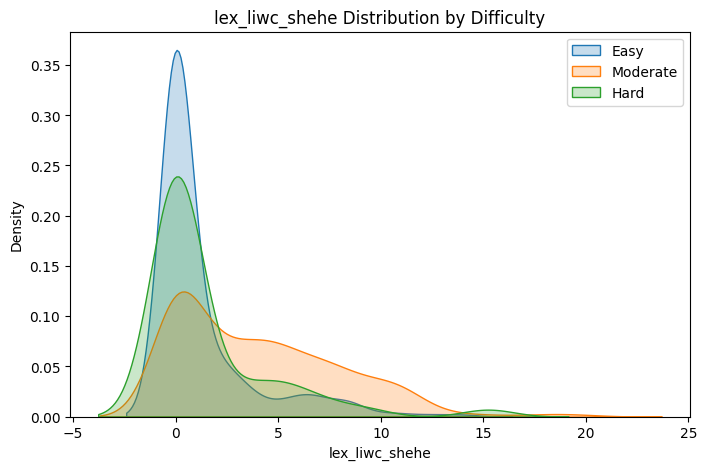

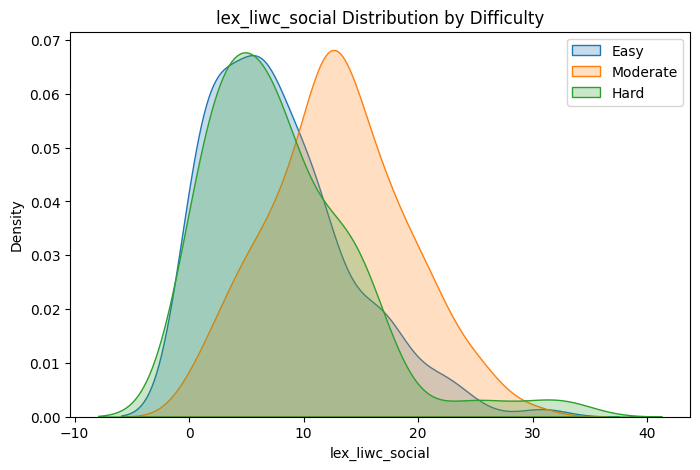

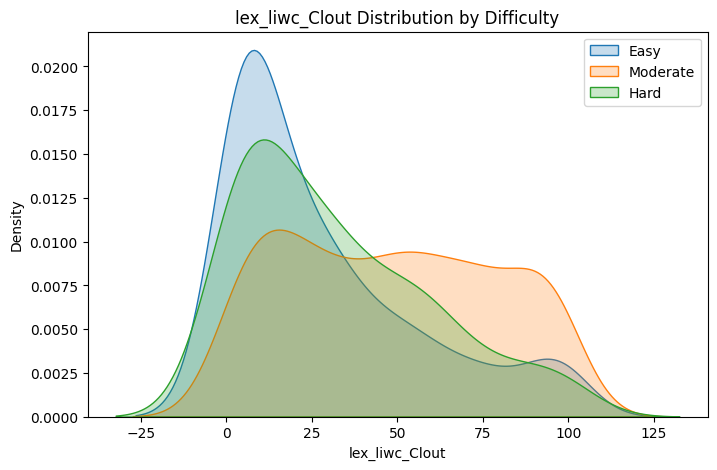

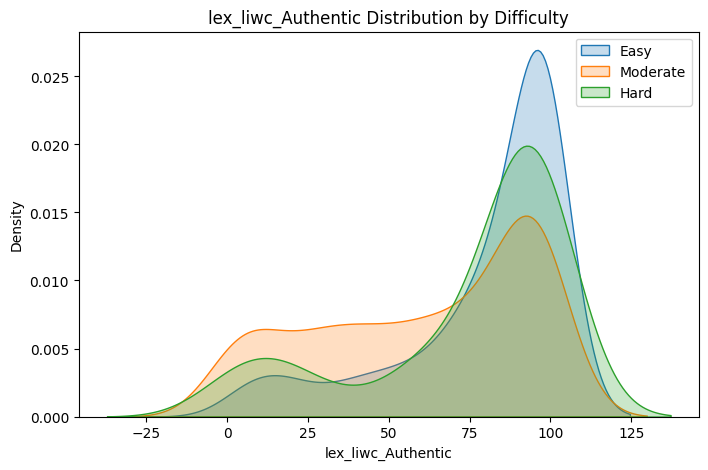

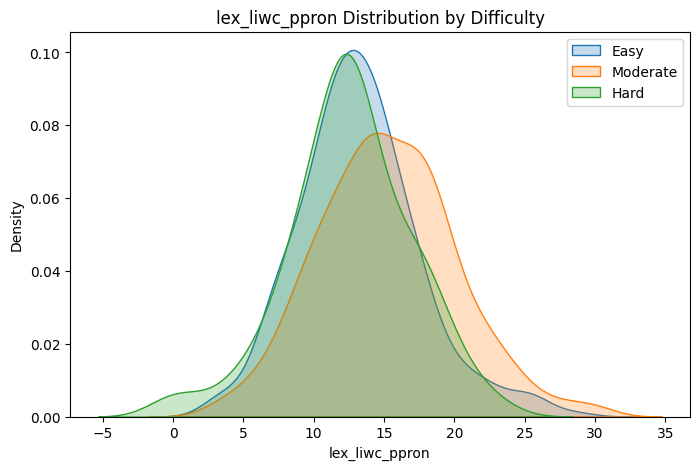

In [ ]:
top_features = ["lex_liwc_shehe", "lex_liwc_social", "lex_liwc_Clout", "lex_liwc_Authentic", "lex_liwc_ppron"]

for feat in top_features:
    plt.figure(figsize=(8,5))
    sns.kdeplot(data=df_test[df_test['difficulty']=="Easy"], x=feat, label="Easy", fill=True)
    sns.kdeplot(data=df_test[df_test['difficulty']=="Moderate"], x=feat, label="Moderate", fill=True)
    sns.kdeplot(data=df_test[df_test['difficulty']=="Hard"], x=feat, label="Hard", fill=True)
    plt.title(f"{feat} Distribution by Difficulty")
    plt.xlabel(feat)
    plt.legend()
    plt.show()

Across the five selected LIWC features, the distributions for the Easy and Hard subreddit categories appear quite similar. This likely reflects the fact that several of the subreddits labeled as Hard actually had very high raw F1 scores, but their normalized ease scores were low due to penalization on their extremely small sample sizes. As a result, the “Hard” category here may be more reflective of subreddits with limited data rather than genuinely distinct language patterns in their posts. Because of this, discussion of the Hard subreddits may be less informative for understanding linguistic differences in prediction difficulty. I'll focus the comparison on Easy and Moderate categories instead, where sample sizes are sufficient and differences in LIWC distributions are more meaningful for interpreting why certain subreddits are easier or harder to predict.


1. lex_liwc_shehe and lex_liwc_ppron   
Both Easy and Moderate subreddits peak at relatively similar LIWC scores, but the Easy subreddits show much higher density at the peak, with a sharper, more concentrated distribution. This suggests that in Easy subreddits, more frequent third-person and personal pronoun usage is consistent across posts, whereas Moderate subreddits show slightly more variability.

2. lex_liwc_social   
Moderate subreddits tend to have higher LIWC scores. This indicates that while social language ("you", "we", "he", "she") appears in both categories, posts in Moderate subreddits may use more social references on average.

3. lex_liwc_Clout and lex_liwc_Authentic   
The peaks of the distributions occur at similar LIWC scores across Easy and Moderate subreddits. However, the distributions for Moderate subreddits are noticeably flatter and more spread out, suggesting greater variability in perceived leadership/status (Clout) and perceived honesty (authenticity) in those posts compared to posts from Easy subreddits.

**Subreddits categorized as Easy (e.g., r/anxiety, r/ptsd) are easier to predict because their posts exhibit more consistent linguistic patterns, particularly in pronoun usage, social references, and markers of authenticity and authority**. This likely allows the model to more reliably detect stress-related language. In contrast, Moderate subreddits (e.g., r/domesticviolence, r/assistance, r/relationships) show greater variability in these features, which may introduce ambiguity and make stress prediction more difficult.  

Therefore, the **ease of predicting stress in a subreddit is not solely determined by the absolute presence of stress-related words, but also by the consistency and concentration of certain linguistic signals across posts**.

# Conclusion

Across attribution and linguistic analyses, the model appears to conceptualize stress as language that is emotionally intense, self-focused, and negative in sentiment. Stress predictions are strongly associated with affectively charged vocabulary and explicit expressions of distress, while non-stress predictions are more frequently driven by neutral discourse markers and less emotionally volatile wording. Stress-driving terms seem to vary by subreddit context as well, suggesting that the model captures context-sensitive semantic patterns too. The model also performed well for subreddits like r/ptsd and r/anxiety because stress-related linguistic signals are both strong and consistent, making the stress status of posts from these subreddits easier to predict. In addition, we've also figured out that mistakes made in prediction (specifically false negatives where model fails to recognize stress posts) do not occur because it fails to recognize stress vocabulary, but rather because stress-related signals are overridden by stronger structural cues associated with the non-stress class. 

## Potential Real-World Applications

At a general level, such a stress-detection model could be implemented as a backend screening tool integrated into online platforms where users generate large volumes of text content. The model could automatically analyze posts in real time and determine if they fall under 'Stress' or 'Non-Stress'. This would allow platform moderators or support teams to prioritize high-risk content without having to manually sift through every post. Beyond moderation support, the model could also be linked to automated but non-intrusive resource recommendations. For instance, when a post is classified as stress, the platform could discreetly suggest relevant support resources (e.g. mental health hotlines) either through a private message or a follow-up prompt.

Scaling this framework to a Singaporean context, the model could be adapted for use within local online communities and social media platforms where discussions about academic stress, employment pressures and financial concerns (some of the main stressors for Singaporeans) are common, such as Reddit (e.g. r/singapore, r/sgexams, and r/asksingapore, which are high-traffic Singaporean-dominated subreddits) or Telegram channels (e.g. NUS ConfessIT, a student-run confession page). Currently, given the high posting volume, moderation is largely reactive and dependent on other users noticing stress signals among numerous daily threads. In the case of the confession channel, there is barely any moderation at all. Implementing such a model provides a scalable way to monitor stress signals across our online communities.

Importantly, the model should function as an assistive layer that supports platform moderators and users rather than become a surveillance mechanism. With appropriate safeguards and transparency, such a system could potentially enhance responsiveness and accessibility of mental health support within Singapore’s fast-paced and digitally active communities.

## Risks

The previous density analyses and comparisons revealed that the model performs best when stress expression is linguistically consistent and emotionally explicit. In contexts where stress is conveyed through intense affective vocabulary with strong first-person focus and clear negative sentiment, the model is more accurate. However, deploying this model in Singapore could introduce some culturally specific risks due to the unique characteristics of Singapore’s linguistic landscape.  

Singaporean online communication frequently incorporates:  
- Singlish discourse particles (“lah”, “lor”, “meh”, "hor")
- code-switching between multiple languages (e.g. English, Mandarin, Malay, Tamil, and various dialects)
- local phrases and local internet references  

The model, which had been trained on western English Reddit data, may underperform when encountering Singlish structures or unfamiliar multilingual phrasing, potentially misinterpreting colloquial expressions or failing to recognize culturally specific stress signals. For example, phrases such as “wah it’s damn shag” or “I feel a bit sian” clearly convey explicit fatigue and emotional strain within our Singaporean context, yet they may lack the typical explicit negative sentiment markers the model has learned to associate with stress, as the model may not understand the meaning of "shag" or "sian". These unrecognizable words may dilute the intensity of negative sentiment tokens, which was an identified issue of the model in earlier analyses. As a result, sentences containing such expressions risk being misclassified as neutral or non-stressful.  

Without proper fine-tuning on Singaporean linguistic data, these factors may collectively reduce the model’s reliability. The risk is not merely reduced accuracy, but increased false negatives among individuals who express stress in more 'Singaporean' ways. Incorporating locally curated stress-expression training data containing our local colloquial markers of fatigue or frustration could help mitigate these lexical blind spots in future. 

## Final Conclusion

Despite these limitations, the model still demonstrates some meaningful practical value. The attribution analyses suggest that it does not rely solely on generic negativity, but instead captures structured and context-sensitive patterns of stress expression. Its ability to differentiate between emotionally explicit distress and neutral discourse (although not without imperfections) indicates that it has learned more than superficial keyword associations. 

In real-world applications, such a model can play a significant supportive role. Its capacity to rapidly process large volumes of text and flag posts exhibiting strong stress signals makes it particularly valuable in environments where manual review is resource-intensive. Platforms such as forums, channels, or community support networks could benefit from automated screenings by the model that help moderators, counselors, or outreach teams prioritize attention more efficiently. By reducing response latency in high-volume settings, the model has the potential to enhance timeliness of support.

Furthermore, even if subtle or culturally moderated expressions of distress are occasionally under-detected, the model still remains highly useful in identifying cases where stress is explicit and potentially urgent regardless of linguistical context. When implemented with appropriate safeguards (such as human-in-the-loop reviews) the model's strengths can be leveraged while minimizing risks of harm.

Ultimately, the model should not be positioned as a diagnostic tool, but as an assistive decision-support system. With responsible deployment and further improvements to adapt it to the Singaporean context, I'm sure it can contribute meaningfully to online mental health support strategies. 